In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## Data load

We begin by loading the necessary data, which will consist of names. The ultimate goal of the algorithm is to generate names. To achieve this, the model will start with three input characters and generate the next character in the sequence. This newly generated character will appended as last character of the previous three and the first one will be removed and then be used as input to predict the subsequent one, and this process will continue...

The models we will implement are character-level language models, meaning they predict the next character in the sequence based on one or more preceding characters.

### Example of how it works

Lets suposuse that our model finally predict the name `hermione`, the sequence will be as follow:

| Input | Output (model prediction) |
|-------|---------------------------|
| ...   | h                         |
| ..h   | e                         |
| .he   | r                         |
| her   | m                         |
| erm   | i                         |
| rmi   | o                         |
| mio   | n                         |
| ion   | e                         |
| one   | .                         |

In [2]:
words = open("data/kharpathy/names.txt", "r").read().splitlines()

print(f"The dataset contains {len(words)} names.")

The dataset contains 32033 names.


In [3]:
# As an example, some of the names in the dataset are ...
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

Now we are going to build to dictionaries:
* `stoi`: map each character to its corresponding index -> `{'.':0, 'a':1, ...}`
* `itos`: map each character index to its corresponding character -> `{0:'.', 1:'a', ...}`

In [4]:
uniques_characters = sorted(set(''.join(words)))
itos = {idx+1:uniq_char for idx, uniq_char in enumerate(uniques_characters)}
itos[0] = '.'

stoi = {v:k for k,v in itos.items()}

print(itos)
print(stoi)

VOCABULARY_SIZE = len(stoi.items())
print(f"Uniques tokens in dataset: {VOCABULARY_SIZE}")

BLOCK_SIZE = 3
print(f"Number of characters used as context in the inputs: {BLOCK_SIZE}")

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Uniques tokens in dataset: 27
Number of characters used as context in the inputs: 3


## Building the splits

In [16]:
def build_dataset(dataset_words):
  """
  This function receive a list of words and return the both samples tensors:
  * X tensor with the inputs (the indexes of the character's sequence)
  * Y tensor with the labels (the indexes of the actual character that follows the sequence)
  """
  X, Y = [], []

  for word in dataset_words:
    input = [0]*BLOCK_SIZE
    for ch in word+'.':
      ch_ix = stoi[ch]
      X.append(input.copy())
      Y.append(ch_ix)
      input = input[1:] + [ch_ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y


import random
random.seed(42)
random.shuffle(words)

# Now we need to calculate the starting and the ending indexes for every split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

print(f"Samples in train split: {Ytr.shape[0]}")
print(f"Samples in train split: {Ydev.shape[0]}")
print(f"Samples in train split: {Ytest.shape[0]}")

Samples in train split: 182625
Samples in train split: 22655
Samples in train split: 22866


## MLP creation

In the following cell we will create the MultiLayer Perceptron

In [11]:
def create_mlp():

  N_EMBD = 10 # Number of dimensions in the embeddings
  N_HIDDEN = 200 # Number of outputs of the first hidden layer

  g = torch.Generator().manual_seed(2147483647)
  C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
  W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g)
  b1 = torch.rand(    N_HIDDEN,                       generator=g)
  W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g)
  b2 = torch.rand(    VOCABULARY_SIZE,                generator=g)

  parameters = [C, W1, b1, W2, b2]

  for p in parameters:
    p.requires_grad = True

  return C, W1, b1, W2, b2, parameters, g


# We iterate over all elements except for the two last because is the list of parameters again and the generator
default_num_params = sum([pa.numel() for pa in create_mlp()[:-2]])
print(f"Our default model have a total of {default_num_params} trainable parameters")

Our default model have a total of 11897 trainable parameters


## Train loop and evaluation

In [ ]:
# Max steps (each step is performed with a batch) to train our model
max_steps = 200000

# Samples in the batch. Each sample will contains BLOCK_SIZE characters
# as input and one character as label
batch_size = 32

# List where we store the loss for every batch
lossi = []


C, W1, b1, W2, b2, parameters, g = create_mlp()

for step in range(max_steps):

  # Randomly build the minibatch: We choose indexes between 0 and number of
  # samples in the training split. We choose as many indexes as batch_size.
  # The result is a tensor with batch_size elements each of them an integer
  # representing an index
  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  # Get the samples by indexing the training dataset
  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  ######## Forward pass ########
  ##############################

  ### Retrieving the batch embeddings ###

  # First we get the embeddings (from the embeddings matrix C) of the samples in
  # this batch. The emb tensor will have shape: (32, 3, 10):
  # * 32 samples
  # * 3 characters (BLOCK_SIZE) per sample
  # * 10 dimensions per embedding
  emb = C[Xb]

  ### First hidden layer pass ###

  # Apply view to emb variable to modify the shape from (32, 3, 10) to (32, 30)
  # which means that we will have as many rows as samples and the columns will
  # be all the 3 (BLOCK_SIZE) embeddings concatenated

  # hpreact comes from hidden preactivation
  hpreact = emb.view(batch_size, -1) @ W1

  hpreact += b1

  ### Activation function pass ###
  h = torch.tanh(hpreact)

  ### Ouput layer pass ###
  logits = h @ W2

  logits += b2

  ##############################
  ##############################

  ######## Optmization step ########
  ##############################

  # Calculate the loss
  loss = F.cross_entropy(logits, Yb)


  # Set to None (equivalent to set to 0) the grads in the parameters
  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01

  # Modify the weights based on the gradients and Learning Rate (lr)
  for p in parameters:
    p.data += -lr*p.grad

  ##############################
  ##############################

  # Track stats every 10k steps
  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  # Before to save the loss in lossi we apply a log transformation to the value
  # the log transformation is made to represent the data easily in a plot,
  # specifically to reduce the hockey stick shape in the plot
  lossi.append(loss.log10().item())


      0/ 200000: 28.422253
  10000/ 200000: 2.429839
  20000/ 200000: 1.898862
  30000/ 200000: 2.420012
  40000/ 200000: 2.548522
  50000/ 200000: 2.425851
  60000/ 200000: 1.821221
  70000/ 200000: 1.970525
  80000/ 200000: 2.443334
  90000/ 200000: 2.261238
 100000/ 200000: 2.129352
 110000/ 200000: 1.992123
 120000/ 200000: 2.190625
 130000/ 200000: 2.152521
 140000/ 200000: 1.993827
 150000/ 200000: 2.475385
 160000/ 200000: 2.227375
 170000/ 200000: 1.753355
 180000/ 200000: 1.726529
 190000/ 200000: 2.203957


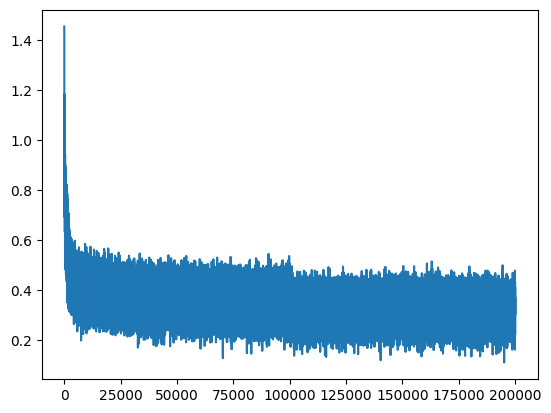

In [ ]:
# Plot the loss got for each step during training
plt.plot(lossi)

## Model evaluation in train and dev splits

In the following cell there is no new code that worth mentions excep for the `@torch.no_grad()` decorator. The function of the decorator is to prevent the gradients of the operations we are going to perform in this cell from being calculated, which makes sense since we don't want to carry out any parameter optimization, we just want to know the loss value in each of the splits.

In [ ]:
@torch.no_grad()
def split_loss(split_name):
  splits_dct = {
      'train':  (Xtr, Ytr),
      'val':    (Xdev, Ydev),
      'test':   (Xtest, Ytest)
  }

  x, y = splits_dct[split_name]

  emb = C[x]
  hpreact = emb.view(x.shape[0], -1) @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f"{split_name} loss: {loss.item()}")


split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.120126724243164
val loss: 2.163686513900757
test loss: 2.167562484741211


## Sampling from the model

Now that we have a trained model we can use it to generate new names sampling from it.

In [ ]:
@torch.no_grad()
def generate_names():

  g = torch.Generator().manual_seed(2147483647 + 10)

  # We are going to generate 20 names
  for i in range(20):
    generated_name = ''
    predicted_character = ''
    input = [0,0,0]
    while predicted_character != '.':

      emb = C[torch.tensor(input)]
      hpreact = emb.view(1, -1) @ W1 + b1
      h = torch.tanh(hpreact)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      pred = torch.multinomial(input=probs, num_samples=1, replacement=True, generator=g)
      predicted_token_ix = pred.item()
      input = input[1:] + [predicted_token_ix]
      predicted_character = itos[predicted_token_ix]
      if predicted_character != '.':
        generated_name += predicted_character
    print(generated_name)


generate_names()

mora
mayah
seel
nah
yamarethan
endrari
adelyn
eliizely
jen
eden
eson
arleigh
malara
noshurergihamiest
jair
jenslen
pace
usamyren
kylene
ehs


### Some comments about softmax function

In the previous cell we have seen that we use the softmax function in the following way: `probs = F.softmax(logits, dim=1)`

Having into account that logits has the shape `(1, 27)` if we apply softmax to `dim=0` what torch will do is create a `27` elements tensor, all of them will be `1.0` because there is just one element by columns. We do not want this. We want to get the softmax across the unique row that exist in logits, or said in other words: we want to compute the softmax throw columns.

We can see this behaviours with an example in the following cell:

In [ ]:
logits_values = torch.tensor([[1,2,3,4]]).float()
print(f"Logits values shape: {logits_values.shape}, so we have {len(logits_values.shape)} dimmensions")
dim_0_softmax = torch.softmax(logits_values, dim=0)
dim_1_softmax = torch.softmax(logits_values, dim=1)

print(f"{dim_0_softmax=}")
print(f"{dim_1_softmax=}")

Logits values shape: torch.Size([1, 4]), so we have 2 dimmensions
dim_0_softmax=tensor([[1., 1., 1., 1.]])
dim_1_softmax=tensor([[0.0321, 0.0871, 0.2369, 0.6439]])


As we can see, the correct option is `dim=1` because is the one that produce a probability distribution.

## Activations and gradients evaluation

In the previous cells we have built, trained and evaluated a model (a MLP). Next we are going to analyze the distributions of actvations, gradients and some other values to spot and get to the root of some issues that we will explain.

The first problem that we can see in our network is easily identifiable if we take a look to the loss plot that we have created previously, we can see the same problem if we take a look to the numerical values of the loss printed during the training. In the first step, before any optimization we have a loss of more or less `28`. Even if later the MLP improves and achieve a reasonable loss this initial values is somthing to worry about. Let see why.


### Why an initial big loss (28) is something weird or at least way too high?

This loss is a consequence of the probabilities that our network assign to each possible character. When the netowrk is created, and obviously not yet trained, there is no evidence for the netowrk to think that any character is more probable that another, basically because it has been randomly initialized so has not seen yet any name.
If this is true all the character should have a probability:

$\frac{1}{numberOfPossibleCharacters} = \frac{1}{27} = 0.037$

In order to have this probability of `0.037` for each character all the logits values should be the same and then after the softmax we will have same probability for all the characters. Let see an example in the following cell:

In [ ]:
# We will create a tensor full of ones but we will have the same softmax output with any other value.
# the only requirement is that all the values should be the same and that we have a tensor which 27 elements
example_logits = torch.ones((1,27))
expected_probs = F.softmax(example_logits, dim=1)
expected_probs

tensor([[0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370]])

As we can see all the probs are the same if all logits are the same. Then if we take this lesson to our network and we expect that in the initialization all the probabilities for all the possible characters are the same we should have similar values for all the logits.

But lets take our analysis a step further. If we know which are the logits that we want to have we can know the loss that we will get in this ideal initialization situation. Our normalized loss, loss per character, will be `log(0.037)` and because we want the negative value of the log in order to obtain a positive value it will be `-log(0.037)`

In [ ]:
-torch.log(torch.tensor(1/27))

tensor(3.2958)

So the loss that we expect without any optimization step is `3.2958`. This value is clearly far away from our current `28`.

In order to get what is the problem let see the logits that our network is assigning to the different characters previously to any optimization step. We will infer using just one example (`batch_size = 1`) to show the simples example but the situation will be the same with any batch size. In fact we are interested in analize the distribution of the probabilities predicted on each sample.

Initial loss: 42.899600982666016


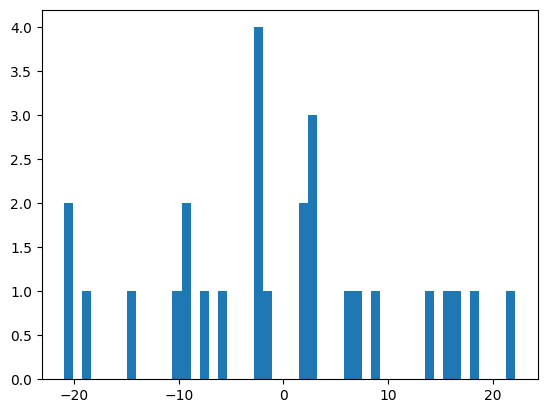

In [ ]:
batch_size = 1

C, W1, b1, W2, b2, parameters, g = create_mlp()

samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

# We are going to do one forward pass without optimization to get the initial logits
Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

emb = C[Xb]

hpreact = emb.view(batch_size, -1) @ W1 + b1

h = torch.tanh(hpreact)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yb)

print(f"Initial loss: {loss.item()}")
plt.hist(logits.view(-1).detach().numpy(), bins=50);

As we can see the values of our logits are in no way similars. The values range from `-20` to almost `20`. In this way when we pass this probabilities by the softmax layer some of the characters are much more likely (the ones with the higher values) than others, and because this is random and we have 27 possible charaters and just 1 correct among them (the label) it is very likely that the character that is being given the highest probability is a wrong one, in fact the possibility of failing is `26/27`. This situation makes that our loss increase.

### Bad initialization fix

As we have seen the difference between logits values is causing our high initial loss. So we need to make them roughly equal. Lets recall how logits are calculated: `logits = h @ W2 + b2`.

One value that could be a valid one for the logits (like any other) is 0, so we dont need to select a given positive or negative value. So,
How can we get all the values ​​to be approximately 0 at initialization?

Lets assume that we can not do nothing with `h` because is the output from the previous layer and we just want to make change in the last one.

The first thing that we can do is to cancel the bias, but we want to have a bias during the training, we just need to cancel it during the first step. For this reason instead of removing the bias we can multiply it by 0 when it is created, in this way the change only affect in the first step. So we go from this `b2 = torch.rand(VOCABULARY_SIZE,generator=g)` to this `b2 = torch.rand(VOCABULARY_SIZE,generator=g) * 0`

Great, now that we have the bias issue solved we still have the problem that we need to compensate the multiplication by `W2`. The `W2` weights are created randomly, but because these values are going to multiply `h` and we want that the result take values near to `0` the thing that we can do is multiply `W2` by a value near to `0` and in this way the values of the logits will be also near to `0`.

Let see if this helps:

Initial loss: 3.504487991333008


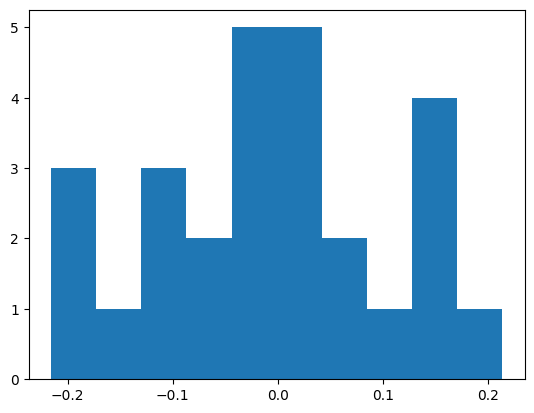

In [ ]:
batch_size = 1

C, W1, b1, W2, b2, parameters, g = create_mlp()

W2 = W2 * 0.01
b2 = b2 * 0

samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

# We are going to do one forward pass without optimization to get the initial logits
Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

emb = C[Xb]

hpreact = emb.view(batch_size, -1) @ W1 + b1

h = torch.tanh(hpreact)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yb)

print(f"Initial loss: {loss.item()}")
plt.hist(logits.view(-1).detach().numpy());

As we can see now our initial loss is closer to the expected one, we are getting a loss of `3.5` and the expected is `3.29`. And this is a consecuence of our logits now being in a range from `-0.2` to almost `0.2`.

Now let see how our training works with these changes:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g)
b1 = torch.rand(    N_HIDDEN,                       generator=g)
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.343801
  10000/ 200000: 2.379513
  20000/ 200000: 1.778878
  30000/ 200000: 2.256877
  40000/ 200000: 2.240792
  50000/ 200000: 2.478317
  60000/ 200000: 1.754869
  70000/ 200000: 2.003558
  80000/ 200000: 2.361878
  90000/ 200000: 2.261316
 100000/ 200000: 2.175098
 110000/ 200000: 2.001903
 120000/ 200000: 2.021498
 130000/ 200000: 2.058007
 140000/ 200000: 1.907248
 150000/ 200000: 2.464737
 160000/ 200000: 2.042911
 170000/ 200000: 1.729685
 180000/ 200000: 1.685881
 190000/ 200000: 2.086530


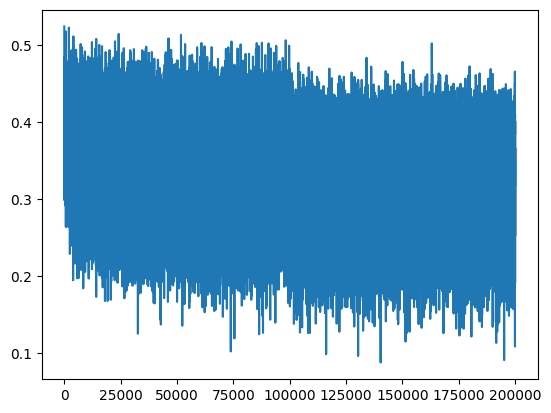

In [ ]:
# Plot the loss got for each step during training
plt.plot(lossi)

The plot does not look any more like a hockey stick becuase the first loss value is much more similar to the trained loss values. So we have fixed the initialization issue. Lets now see if this improvement has taken us to a better model (a model with lower loss value):

In [ ]:
split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.0687057971954346
val loss: 2.1296653747558594
test loss: 2.1294143199920654


Our model seem to have improved a little bit as you can see in the followiing comparation table:


|            | Random initialization | Random initialization with (W2,b2) multiply by gains |
|------------|-----------------------|---------------------------------------------------|
| Train loss | 2.12012672            | 2.0687057                                         |
| Val loss   | 2.1636865             | 2.12966537                                        |
| Test loss  | 2.16756248            | 2.1294143199                                      |


This is due to the fact that the model no longer needs to dedicate the first few iterations to correcting the problem, logit values ​​distributed over a wide range, at initialization and can dedicate these iterations to improving the model. In any case, our model is still small and the observed difference is not too large, but we must keep in mind that these problems get worse as the size of the models increases.

### Hidden state values analysis (first layer output)

We are going now to initialize again our network and go a step further. We are going to check the values that the first layer before any optimization step:

Initial loss: 3.343801498413086


Text(0.5, 1.0, 'Hidden state value Pre Tanh activation')

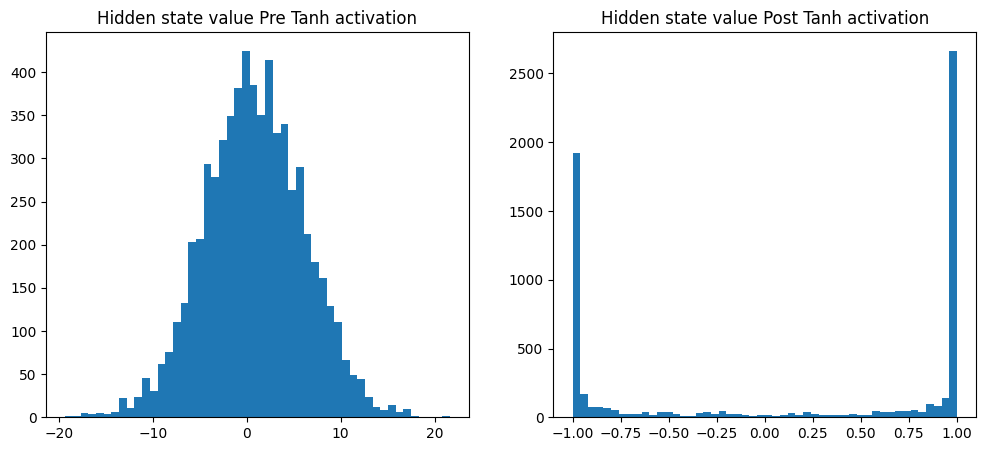

In [ ]:
batch_size = 32


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g)
b1 = torch.rand(    N_HIDDEN,                       generator=g)
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True



samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

emb = C[Xb]

hpreact = emb.view(batch_size, -1) @ W1 + b1

h = torch.tanh(hpreact)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yb)

for p in parameters:
  p.grad = None

loss.backward()

C_grads = parameters[0].grad
W1_grads = parameters[1].grad
b1_grads = parameters[2].grad
W2_grads = parameters[3].grad
b2_grads = parameters[4].grad

print(f"Initial loss: {loss.item()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first plot
ax2.hist(h.view(-1).detach().numpy(), 50);
ax2.set_title('Hidden state value Post Tanh activation')

# Plot the second plot
ax1.hist(hpreact.view(-1).detach().numpy(), 50);
ax1.set_title('Hidden state value Pre Tanh activation')

We have created in the previous cell two plots:
* the one on the right shows the distribution of the hidden state values `h` before the Tanh activation, ie. `hpreact` : `hpreact = emb.view(batch_size, -1) @ W1 + b1`
* the one on the left shows the distribution of the hidden state values `h` after the Tanh activation, ie. `h`: `h = torch.tanh(hpreact)`

We can see that although the values ​​prior to activation show a clear normal distribution. which is normally desirable, at least at this point after initialization, the values ​​after the activation function are almost all in the extreme areas of the output values ​​of the Tanh function, that is `-1` and `1`.

This behavior is easily explainable since we see that the values ​​in hpreact are in a wide range, between `-20` and `20` and the tanh function maps any value below or above `-1` and `1` to `-1` and `1` respectively.

This zone of the Tanh function is also known as the saturation zone and in our case it is the cause of a problem that we will now describe.

Lets recall the Tanh function and the Tanh derivative formulas:

$Tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

$\frac{d}{dx} \tanh(x) = 1 - \tanh^2(x)$

And let see the plots of both formulas:

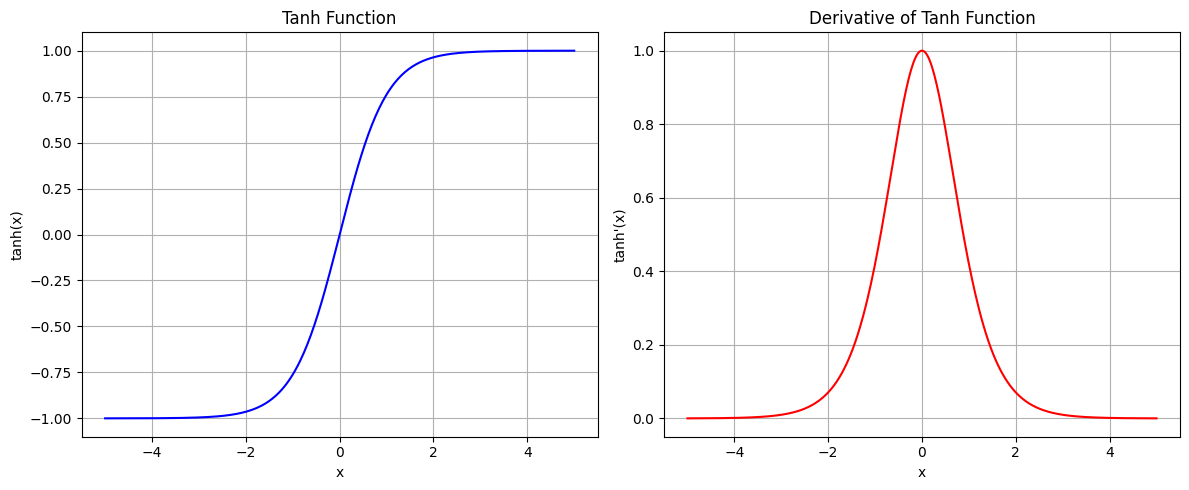

In [ ]:
# Define the x values
x = np.linspace(-5, 5, 400)

# Calculate the tanh and its derivative
tanh_x = np.tanh(x)
tanh_derivative = 1 - tanh_x**2

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the tanh function
ax1.plot(x, tanh_x, color='blue')
ax1.set_title('Tanh Function')
ax1.set_xlabel('x')
ax1.set_ylabel('tanh(x)')
ax1.grid(True)

# Plot the derivative of tanh
ax2.plot(x, tanh_derivative, color='red')
ax2.set_title('Derivative of Tanh Function')
ax2.set_xlabel('x')
ax2.set_ylabel("tanh'(x)")
ax2.grid(True)

# Adjust the spacing between the plots
plt.tight_layout()

# Show the plots
plt.show()


As we can see the derivative in the saturated area is almost `0` this is a problem because it means that the gradient of the value. It is a problem because the gradient of those outputs of the layer whose values ​​are close to `1` will have an almost zero gradient, which will make it difficult for both these values ​​and the following ones in the graph to modify their weights and therefore be optimized.

To confirm this lets take a look to the distributions of the gradients in `W2` (
a post-Tanh layer and therefore not affected by its gradient in back propagation) with the gradients in `W1` and `C` (both preTanh layers and therefore affected by the almost `0` gradient by the back propagation). We will probably have the same situation in `b1` but we are not going to plot it by simplicity.

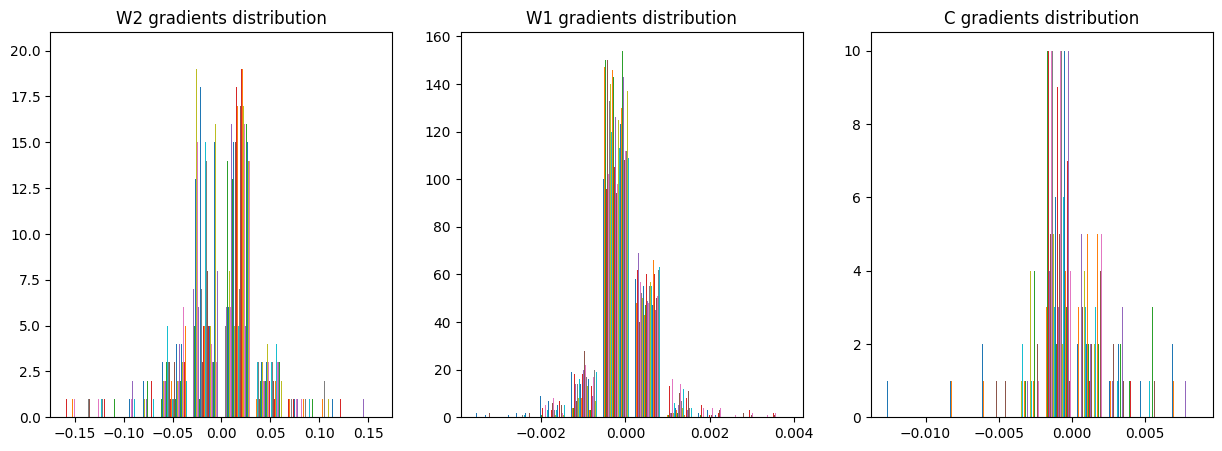

In [ ]:
import matplotlib.pyplot as plt

# Sample data for the plots
x = [1, 2, 3, 4, 5]
y1 = [1, 4, 9, 16, 25]
y2 = [1, 8, 27, 64, 125]

# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(W2_grads);
ax1.set_title('W2 gradients distribution');

ax2.hist(W1_grads);
ax2.set_title('W1 gradients distribution');

ax3.hist(C_grads);
ax3.set_title('C gradients distribution');

We can see that while `W2` gradients are in a range between `-0.15` and `0.15` the gradients in `W1` and `C` are two orders of magnitude below with absolute values ​​closer to `0.005` or `0.002`. These small values ​​will make it difficult to vary (optimize) the values ​​of the current weights, remember that the way to calculate the new weight is: `p.data += -lr * p.grad` so the values will be even smaller after been multiplied by the learning rate.


As last explanation we can take a look to how the gradient for the Tanh is calculated in the micrograd library. The chain rule in the Tanh is applies as follow:

`self.grad += (1 - t**2) * out.grad`

being `t` the ouput of the Tanh function. In this way if the output values are near to `1` or `-1` the term `(1 - t**2)` is going to be almost (if not completely) cancelled and so will be the gradient, at least for this summand.

Now that we know what is happening let see another way to visualize what is happening in the values of `h` (the values that Tanh function output). We are going to plot every value in `h`, the white pixels (small squares) will be the values in the saturated area (absolute value over 0.99) and the black ones the rest of the values:

Percentage of saturated values in h: 61.765625%


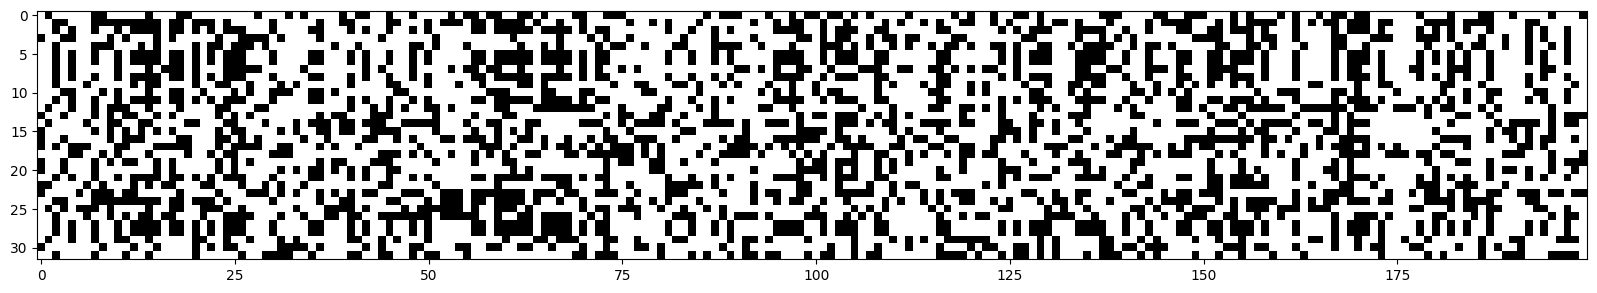

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

print(f"Percentage of saturated values in h: {(h.abs() > 0.99).sum()*100 / h.numel()}%")

As we can see in the plot there is a huge ammount of saturated values, over 60% of the values are saturated (in 32 samples, each of them outputing 200 values).

This situation as we can imagine is not the ideal one, but there is yet another possible worst situation: a neuron can learn even if there are some saturated values because the batch is made up, in our case, by 32 samples, so if one sample produce a saturated value, and then a 0 gradient, probably another value will produce a non-zero gradient and the neuron can learn something. But what happens if all the samples in the batch produce a 0 gradient? in this case we have a dead neuron and it can't learn anythong at least from this batch.

We can identify this situation in our plot looking for a full white column. In our plot it seems that this situation does not happen but it can occur if for example we use a smaller batch size.

### Functions with flat regions (gradient 0 regions)

As we can see in the next plot other activation functions also suffer from this flat areas, this is the case of the sigmoid and ReLu function.

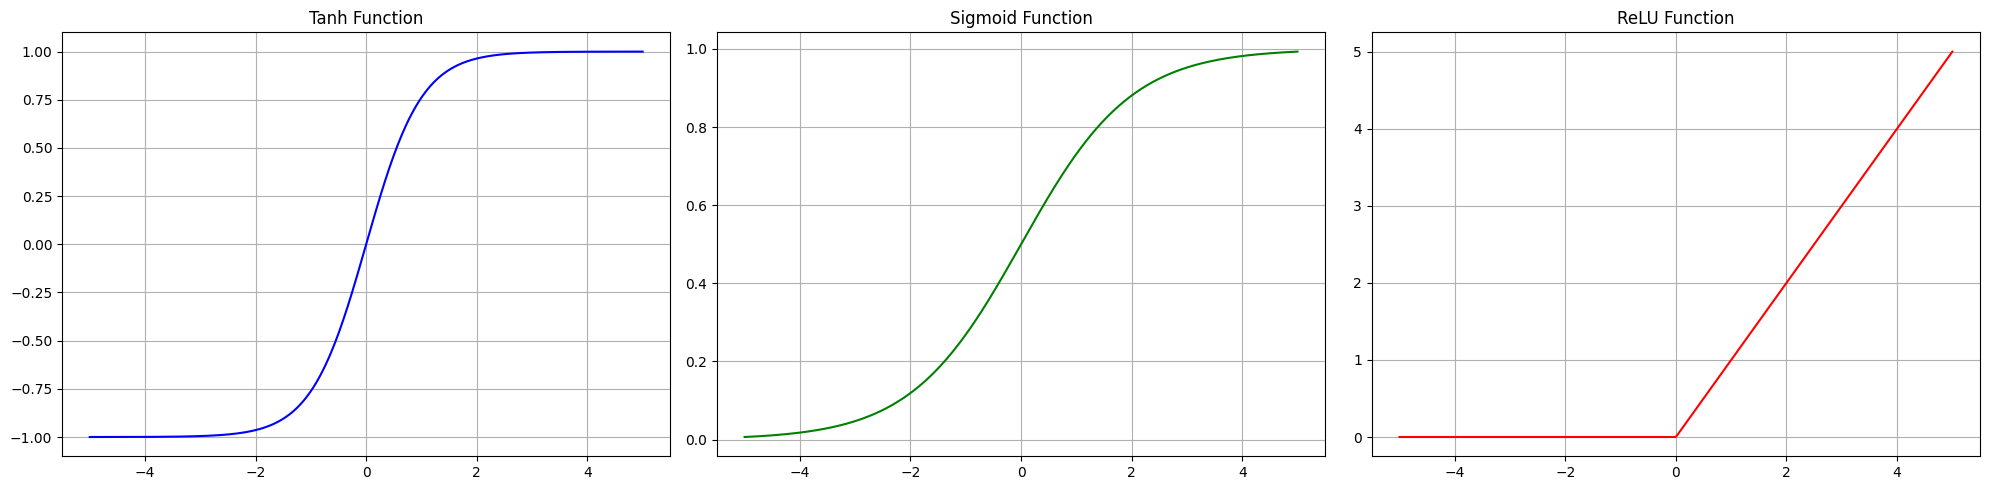

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values
x = np.linspace(-5, 5, 400)

# Define the activation functions
tanh_x = np.tanh(x)
sigmoid_x = 1 / (1 + np.exp(-x))
relu_x = np.maximum(0, x)

# Create a figure with six subplots (2x3 grid)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot Tanh
axes[0].plot(x, tanh_x, color='blue')
axes[0].set_title('Tanh Function')
axes[0].grid(True)

# Plot Sigmoid
axes[1].plot(x, sigmoid_x, color='green')
axes[1].set_title('Sigmoid Function')
axes[1].grid(True)

# Plot ReLU
axes[2].plot(x, relu_x, color='red')
axes[2].set_title('ReLU Function')
axes[2].grid(True)
# Adjust the spacing between the plots
plt.tight_layout()

In order to fix this behaviors other functions, like Leaky Relu or ELU, has been proposed as activations, as you can see in the plot this functions do not have flat areas so always there will be a gradient.

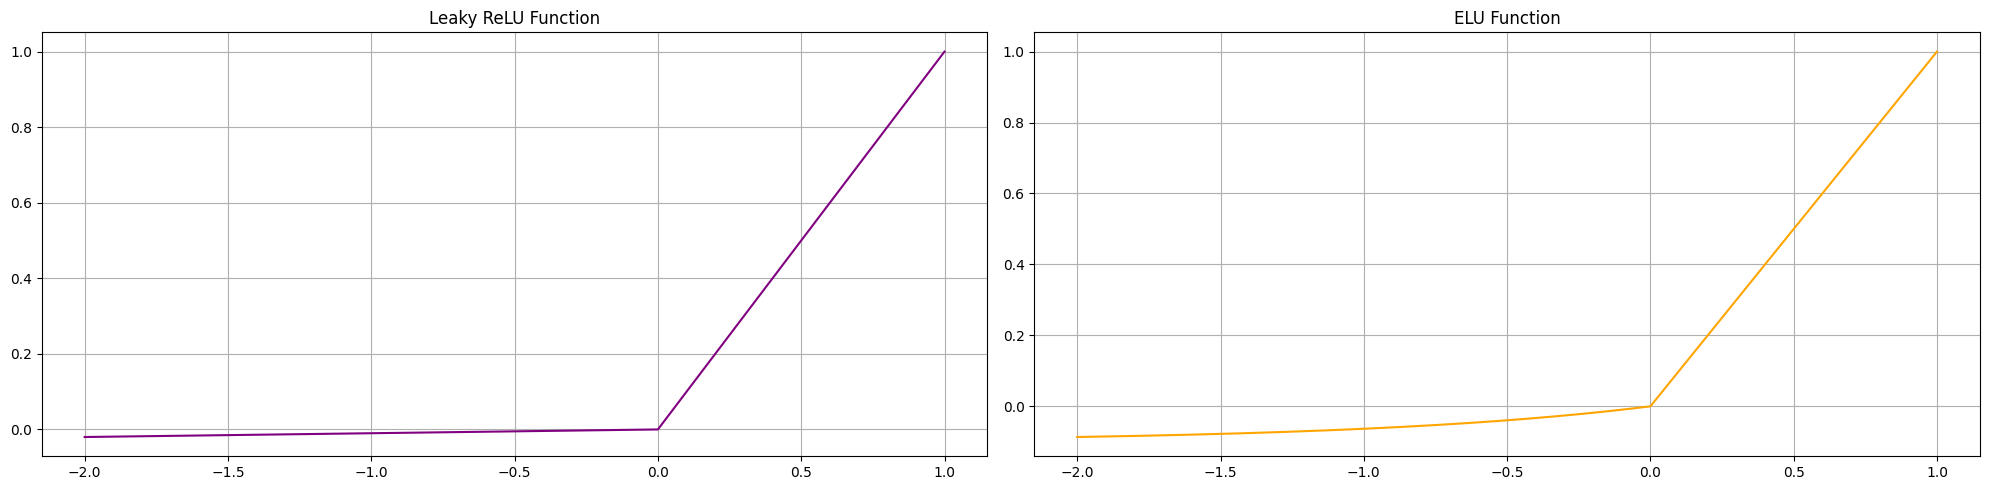

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values
x = np.linspace(-2, 1, 400)

# Define the activation functions
leaky_relu_x = np.where(x > 0, x, 0.01 * x)
elu_x = np.where(x > 0, x, 0.1 * (np.exp(x) - 1))

# Create a figure with six subplots (2x3 grid)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot Leaky ReLU
axes[0].plot(x, leaky_relu_x, color='purple')
axes[0].set_title('Leaky ReLU Function')
axes[0].grid(True)

# Plot ELU
axes[1].plot(x, elu_x, color='orange')
axes[1].set_title('ELU Function')
axes[1].grid(True)

# Adjust the spacing between the plots
plt.tight_layout()

So now that we know what is happening lets try to fix the situation.

Lets recap:
1. We are getting some values with `0` gradients
2. The `0` gradient is caused by the saturated values at the ouput of Tanh activation
3. The saturated values are caused by values near to `-1` or `1` as input in Tanh. Or said in another way values far away from `0`
4. The Tanh input values are calculated as `hpreact = emb.view(batch_size, -1) @ W1 + b1`

So as a conclusion we need to make smaller (closer to `0`) the values in `hpreact`. We can achieve this scaling, by a small values, the values in `W1` and `b1`. Lets do this and take a look again to the distributions, in this case we will multiply `W1` by `0.2` and `b1` by `0.01` in the initialization. We could also can `b1` multypling it by `0` but Kharpathy says that is better to keep some enthropy:

Initial loss: 3.3283004760742188


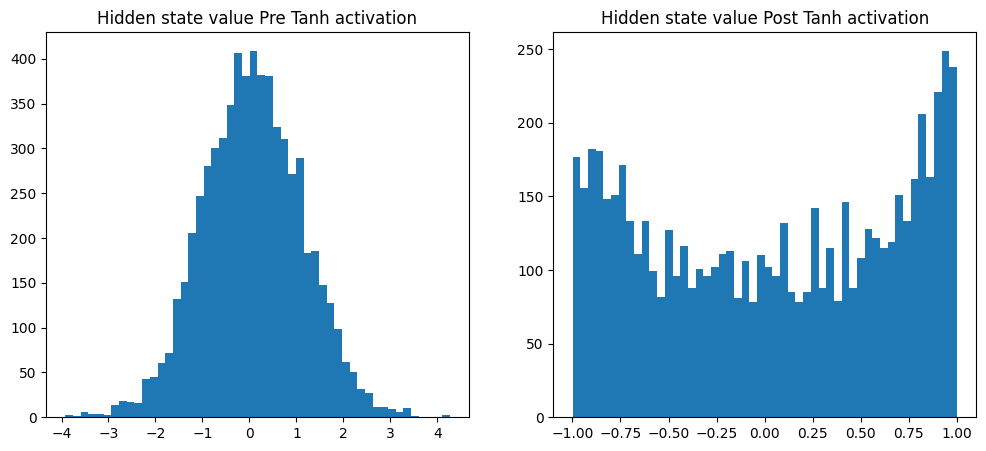

In [ ]:
batch_size = 32


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * 0.2
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True



samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

emb = C[Xb]

hpreact = emb.view(batch_size, -1) @ W1 + b1

h = torch.tanh(hpreact)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Yb)

for p in parameters:
  p.grad = None

loss.backward()

C_grads = parameters[0].grad
W1_grads = parameters[1].grad
b1_grads = parameters[2].grad
W2_grads = parameters[3].grad
b2_grads = parameters[4].grad

print(f"Initial loss: {loss.item()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first plot
ax2.hist(h.view(-1).detach().numpy(), 50);
ax2.set_title('Hidden state value Post Tanh activation');

# Plot the second plot
ax1.hist(hpreact.view(-1).detach().numpy(), 50);
ax1.set_title('Hidden state value Pre Tanh activation');

Percentage of saturated values in h: 1.578125%


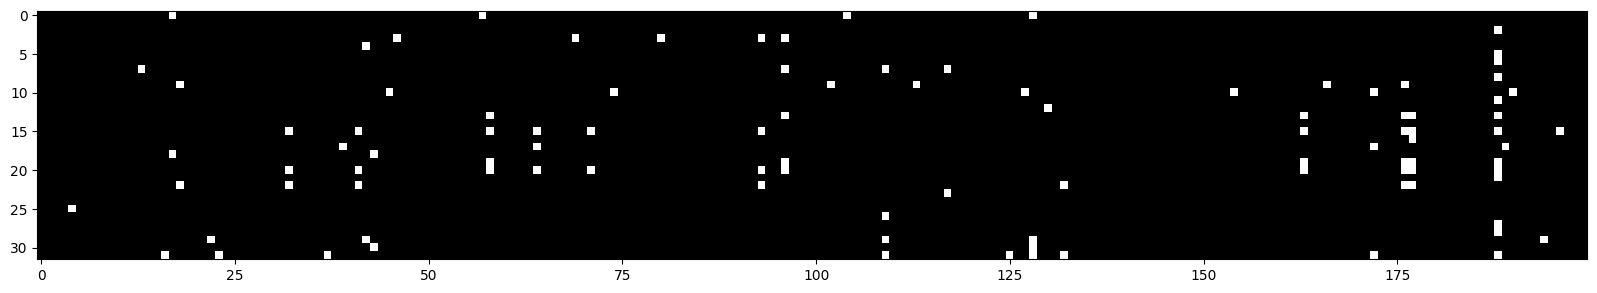

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

print(f"Percentage of saturated values in h: {(h.abs() > 0.99).sum()*100 / h.numel()}%")

In the previous plot we see some improvements:
* The values in the `hpreact` range from `-4` to `4`. A great improvement compared to the `hpreact` values ​​we were achieving before applying the scaling (ranging from `-20` to `20`)
* As a result of the improvement in `hpreact` the values in Tanh are not saturating we can see it the distribution of the `h` values
* Finally we see that just the 1.58% of the `h` values are saturating

So now that it seems that we have fixed the situation let run a full training cycle with the new gains to check if we can achieve a lower loss at the end:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * 0.2
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.328300
  10000/ 200000: 2.426466
  20000/ 200000: 1.651590
  30000/ 200000: 2.196092
  40000/ 200000: 2.310720
  50000/ 200000: 2.256381
  60000/ 200000: 1.673529
  70000/ 200000: 1.987536
  80000/ 200000: 2.283910
  90000/ 200000: 2.104937
 100000/ 200000: 2.077113
 110000/ 200000: 2.006039
 120000/ 200000: 2.104881
 130000/ 200000: 2.046035
 140000/ 200000: 1.891321
 150000/ 200000: 2.592187
 160000/ 200000: 2.053278
 170000/ 200000: 1.590181
 180000/ 200000: 1.718358
 190000/ 200000: 1.971744


Now lets evaluate the loss in the three splits to check if we are getting better results:

In [ ]:
split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.0353825092315674
val loss: 2.0994465351104736
test loss: 2.1011343002319336


Just as a way to easily compare the results that we have achieved with the improvements applied we are going to summarize it in the following table:

|            | Original   | Fixed softmax confidently wrong | Fixed Tanh layer too saturated at init |
|------------|------------|---------------------------------|----------------------------------------|
| Train loss | 2.12012672 | 2.0687057                       | 2.03538250                             |
| Val loss   | 2.1636865  | 2.12966537                      | 2.0994465                              |
| Test loss  | 2.16756248 | 2.1294143199                    | 2.10113430                             |

As we can see with every imporvement we have also improved the loss values.

Maybe we are thinking we if the issues that we have spotted are so important our network can achieve a good result with none of the proposed improvements. This is because our network is small and the task to solve is not yet very difficult but when we work with bigger networks all this issues is going to stack layer after layer and we are going to have much more serious problems trying to train our network.

## How to choose good gains values

Until now we have applied gains that we think that could be ok, the only requirement was the gains made the values small enough o directly cancel some values, like in the case of the bias `b2`. But there are two questions worth asking:
* Could there be other values ​​that work more optimally when it comes to solving our problems? It may be that the scaling we have used is too small or too large
* What happens if our network has many more layers? We should manually assign gain values ​​to each of them and see if they work correctly and if not, try other combinations of values.

These two questions can be summarized in one: Can we find an automatic way, or one that follows some objective criteria, to select these gain values ​​so that we can apply it to any network regardless of its number of layers?

In order to answer this questions lets take a look to the following situation: We are going to create one fictional input tensor `x` and one fictional multipliying layer `w` and lets check the distribution of the inputs values and also the output (after the multiplication) values:

Input stats: mean = 0.016999, std = 0.988579
Output stats: mean = 0.007921, std = 3.133118


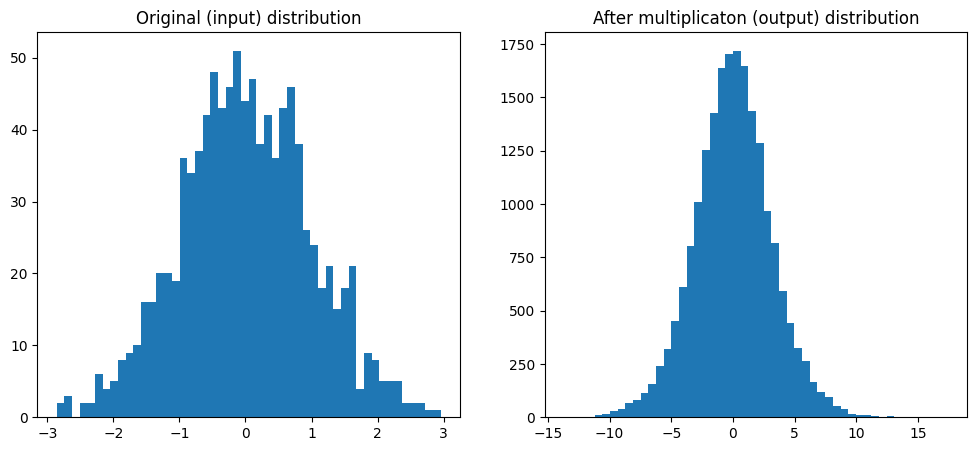

In [ ]:
x = torch.randn((100, 10))
w = torch.randn((10, 200))

y = x @ w

print(f"Input stats: mean = {x.mean():4f}, std = {x.std():4f}")
print(f"Output stats: mean = {y.mean():4f}, std = {y.std():4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(x.view(-1).detach().numpy(), bins=50);
ax1.set_title('Original (input) distribution');
ax2.hist(y.view(-1).detach().numpy(), bins=50);
ax2.set_title('After multiplicaton (output) distribution');

we can see that while the average value remains close to `0` in both distributions the standard deviation has increased after the multiplication operation (original std = `0.97`, output std = `3.097`).

So the question is which is the gain that we need to apply to `w` to preserve the original distribution (mean close to `0` and std close to `1`) at the multiplication's output.

As we can see in the following cell a big gain in `w2` will make that our std grow too much but a small gain will also make it too much small:

Input stats: mean = -0.025131, std = 0.997511
Output Big gain stats: mean = 0.017061, std = 15.621021
Output Small gain stats: mean = 0.000682, std = 0.624841


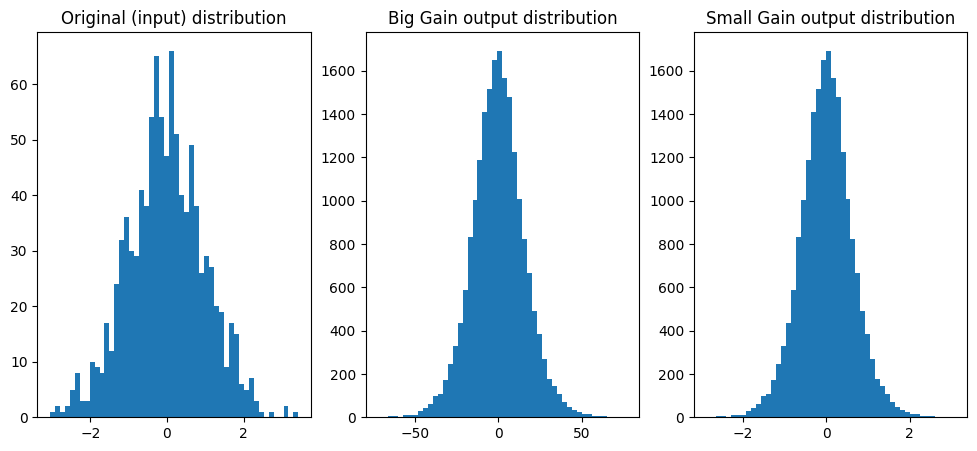

In [ ]:
x = torch.randn((100, 10))
w = torch.randn((10, 200))

w_big_gain = w * 5
w_small_gain = w * 0.2

y_big_gain = x @ w_big_gain
y_small_gain = x @ w_small_gain

print(f"Input stats: mean = {x.mean():4f}, std = {x.std():4f}")
print(f"Output Big gain stats: mean = {y_big_gain.mean():4f}, std = {y_big_gain.std():4f}")
print(f"Output Small gain stats: mean = {y_small_gain.mean():4f}, std = {y_small_gain.std():4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.hist(x.view(-1).detach().numpy(), bins=50);
ax1.set_title('Original (input) distribution');
ax2.hist(y_big_gain.view(-1).detach().numpy(), bins=50);
ax2.set_title('Big Gain output distribution');
ax3.hist(y_small_gain.view(-1).detach().numpy(), bins=50);
ax3.set_title('Small Gain output distribution');

If we want to achieve the same std as the input after the multiplication we should apply a gain that is the inverse to the square root of the fan-in (number of input neurons):

$\frac{1}{\sqrt{InputNeurons}}$

We can find an explanation of this [here](https://stackoverflow.com/questions/58355854/initialisation-of-weights-for-deeplearning-model).

Lets check if this method achieve what we want:

Input stats: mean = 0.001608, std = 0.992523
Output stats: mean = 0.002745, std = 0.957759


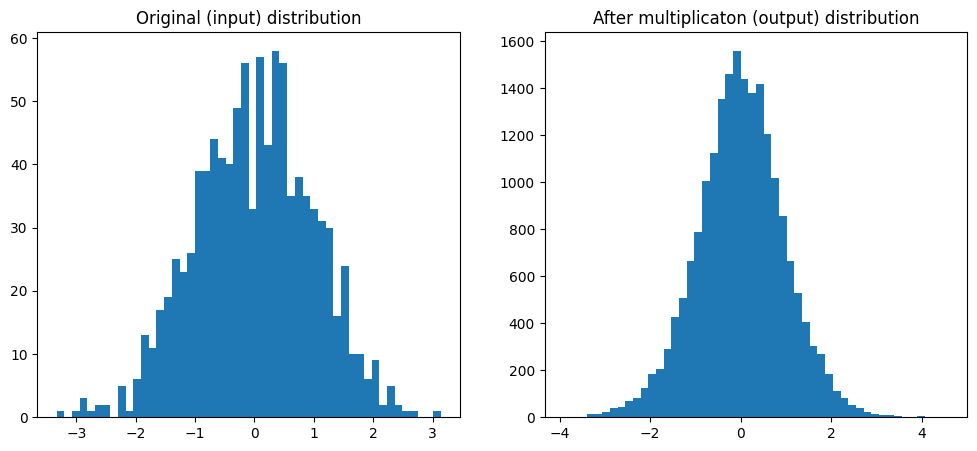

In [ ]:
x = torch.randn((100, 10))

input_neurons = 10
gain = 1/np.sqrt(input_neurons)
w = torch.randn((input_neurons, 200)) * gain

y = x @ w

print(f"Input stats: mean = {x.mean():4f}, std = {x.std():4f}")
print(f"Output stats: mean = {y.mean():4f}, std = {y.std():4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(x.view(-1).detach().numpy(), bins=50);
ax1.set_title('Original (input) distribution');
ax2.hist(y.view(-1).detach().numpy(), bins=50);
ax2.set_title('After multiplicaton (output) distribution');

As we can see now both, input and output, have a mean ≈ `0` and std ≈ `1`.

It has been very easy to achieve our goal with our ,almost, single layer neural network but as we keep adding layer new problems can arise. There has been a huge amount of papers that works on this problem of layer initialization in order to keep the values in a reasonable range along all the neural network, one of the most important one is [this one](https://arxiv.org/abs/1502.01852) that focus its analysis in convolutional neural network and the ReLu and PReLu activations functions (non linearities). In the paper the authors show that because some activation discard part of the output's distribution (for example Relu discard the negative part of the ouput) you need to apply a gain in the weights to keep the properties of the distribution (especifically the std = `1`) this gain will depend on the number of input neurons (`fan_in`) and the activation function that you are going to apply to the output. I have not been able to demonstrate that with Kaiming initialization you achieve std = `1` after a multiplication and a relu layer pass.

In any case, fortunately, nowadays exists news techniques that let us relax this initialization because this methods take care to keep the distributions in the intermediate layers. In this direction the techniques focuses on diferent neural network stage:
* Optimization techniques like RMSProp and Adam, among others...
* Layer noramlization, being the first of this techniques proposed the batchnorm

So for now we are going to stick to the recomended values in the paper for the std, we can check this values [here](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_). The paper says that we need to create a gain of:

$\frac{Activation\_Dependant\_Gain}{\sqrt{fan\_in}}$

We use the `fan_in` (number of neurons in the input) because we want to standardize the output, if we want to standardize the gradients we should use `fan_out` (number of output neurons). Regarding the `Activation_Dependant_Gain` because we are using Tanh activation we should use a value of `5/3`. Then our neural network definition will be as we see in the following cell. Lets train it and see if we get some improvements in the final losses:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.335773
  10000/ 200000: 2.416205
  20000/ 200000: 1.734055
  30000/ 200000: 2.260207
  40000/ 200000: 2.243165
  50000/ 200000: 2.326230
  60000/ 200000: 1.649897
  70000/ 200000: 1.884385
  80000/ 200000: 2.252871
  90000/ 200000: 2.182608
 100000/ 200000: 2.157494
 110000/ 200000: 1.949840
 120000/ 200000: 2.011696
 130000/ 200000: 2.080807
 140000/ 200000: 1.878189
 150000/ 200000: 2.550366
 160000/ 200000: 2.009959
 170000/ 200000: 1.636705
 180000/ 200000: 1.612078
 190000/ 200000: 2.093204


In [ ]:
split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.0394577980041504
val loss: 2.107869863510132
test loss: 2.102546215057373


We can see that with the new initialization method, which allows us not to have to give arbitrary gain values ​​but rather use the activation function and the number of input neurons as criteria to calculate said gain, we are obtaining similar loss results as to the best previously obtained which is good news.

## Batch Normalization

This method proposed [here](https://arxiv.org/abs/1502.03167) made possible to train very deep neural network quite reliably.

We will start explaining batch normalization focusing in our especific case. We have the output tensor of the first (hidden) layer stored in `hpreact`. We do not want the values ​​of this tensor to be either too small (close to `0`) (because the subsequent Tanh function will map them to also values close to `0`) or too large (because the subsequent Tanh function will map them to the flat regions and we will have problems with the gradients in the backprop phase) what we want is that this values follows a roughly gaussian distribution with mean = `0` and std = `1` at least in the initialization phase. Because of this what the BatchNorm paper says is: Why not just normalize the output values to be gaussian?

As we know normalize (standardize) a list of values is just substract them by the sum of all (centering them ie. make the mean equal to `0`) and divide them by their standard deviation (scaling them ie. make the standard deviation equal to `1`). And maybe it sound a little crazy but we can do it because standardization is a perfectly differentiable operation so it is not going to be a problem in the backward pass.

Lets implement this idea. The firs thing that we need to do is to generate a `hpreact` to experiment with it:

In [ ]:
N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g)
b1 = torch.rand(    N_HIDDEN,                       generator=g)
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

emb = C[Xb]

hpreact = emb.view(batch_size, -1) @ W1 + b1

In [ ]:
# The shape of hpreact is (32, 200):
# * 32 because the batch size
# * 200 because the hidden units
# Or said in another way 200 values per each input sample
hpreact.shape

torch.Size([32, 200])

In order to standardize `hpreact` we need to calculate its mean and standard deviation. But this statistics should be computed for each one of the hidden units (200 in our case) and having into account the values in all the batch (that's why we say batch normalization).

Lets start with the mean:

In [ ]:
# The hpreact_mean will have one row, and 200 columns ie.
# one calculated mean per hidden unit
hpreact_mean = hpreact.mean(dim=0, keepdim=True)
hpreact_mean.shape

torch.Size([1, 200])

And now we will do the same but for standard deviation:

In [ ]:
# The hpreact_std will have one row, and 200 columns ie.
# one calculated std per hidden unit
hpreact_std = hpreact.std(dim=0, keepdim=True)
hpreact_std.shape

torch.Size([1, 200])

Now this is how we apply the stardadization formula:

$z = \frac{x - \mu}{\sigma}$

In [ ]:
hpreact_standardized = (hpreact - hpreact_mean)/hpreact_std

And we calculate mean and std of the standardized values to check that all is ok, we will check that all means and std across the batch samples are close to `0` and `1` respectively:

In [ ]:
tolerance = 1e-3

print(f"All means are close to 0?: {torch.all(torch.isclose(hpreact_standardized.mean(dim=0), torch.tensor(0.0), atol=tolerance))}")
print(f"All std are close to 1?: {torch.all(torch.isclose(hpreact_standardized.std(dim=0), torch.tensor(1.0), atol=tolerance))}")

All means are close to 0?: True
All std are close to 1?: True


That's great! Now we can simply add this operation in the neural network with a new step like:

`hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)`

And this will work because mean and std are differentiable operations. But now we have introduced a new issue. We want this standard distribution in the ouputs but just in the initialization. After the initialization the network, through, the training process should be able to adapt this gaussian distribution scaling and shifting it as is required by the data and the objective loss function (the task itself at last) but right now our `hpreact` values do not have this flexibility, right now they are being standardized on every step, always becoming mean = `0` and std = `1`.

In the BatchNorm original paper (previously mentioned) the authors introduced a mechanism to give to the layers that use BatchNorm this flexibility. They suggest to add to terms in the standardization formula: a *scale* and a *shift* term. With this addition the formula is as follows:

$z = \gamma * \frac{x - \mu}{\sigma} + \beta$

Being $\gamma$ the *scale* term and $\beta$ the *shift* term.

This two terms, when it comes to the implementation, will be also tensors, and we need to create one *scale* value and one *shift* value for each output value of batchnorm. So in our case both terms will have 200 values. Another important point is that we do not know which are this values, this is something that the network should learn as it is trained. What we know is that at the start of the training we dont want that this terms modify the perfect standard distribution that we have in the batchnorm output, for this reason *scale* will be initialized as `1`s (because this term multiply) and *shift* will be initialized as `0`s (because this term adds). From now on we will call shift as bias to consistency with neural networks terminology. Let see how in code:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias= torch.zeros((1, N_HIDDEN))

# We will include this parameters in the list of parameters to optimize
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  # Applying BATCH NORMALIZATION
  hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.310837
  10000/ 200000: 2.349814
  20000/ 200000: 1.667135
  30000/ 200000: 2.148181
  40000/ 200000: 2.386145
  50000/ 200000: 2.399870
  60000/ 200000: 1.643886
  70000/ 200000: 2.019191
  80000/ 200000: 2.265709
  90000/ 200000: 2.237108
 100000/ 200000: 2.092177
 110000/ 200000: 2.029357
 120000/ 200000: 2.054025
 130000/ 200000: 2.177371
 140000/ 200000: 1.956647
 150000/ 200000: 2.506217
 160000/ 200000: 2.125003
 170000/ 200000: 1.701861
 180000/ 200000: 1.734681
 190000/ 200000: 2.062406


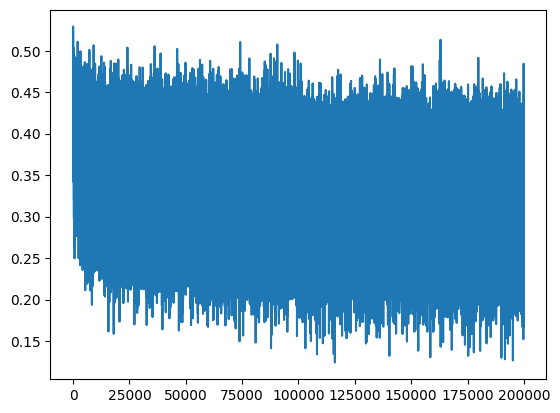

In [ ]:
# Plot the loss got for each step during training
plt.plot(lossi)

We need to modify the `split_loss` to include the Batch normalization step:

In [ ]:
@torch.no_grad()
def split_loss(split_name):
  splits_dct = {
      'train':  (Xtr, Ytr),
      'val':    (Xdev, Ydev),
      'test':   (Xtest, Ytest)
  }

  x, y = splits_dct[split_name]

  emb = C[x]
  hpreact = emb.view(x.shape[0], -1) @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f"{split_name} loss: {loss.item()}")


split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.068425178527832
val loss: 2.108194589614868
test loss: 2.1077675819396973


As we can see, there is no significant improvement compared to the results obtained previously. This is something expected because we are dealing with a very simple network (just one hidden layer) this is also the reason why we have been able to set the values manually for the gain of the hidden layer, when the network starts to growth and it becomes larger and complex this is not something that we can do manually. Compare to that is much more easy to simply put batchnorm layers after every multiplicative layer (the ones that can modify the distribution of the values scaling it for example) like our `W1`.

### Weird thing with Batch Normalization

Until now all the layers and steps that we have seen in the network was deterministic in the sense that given a certain input, certain weights and certain bias values the output would always be the same since all we did was execute a multiplication and an addition. BatchNorm alter this behaviour because now the output not only depends on the input values ​​of the sample in question, but also on the rest of the samples that accompany it in the batch, which are used to calculate the mean and the std (and obviously the batch is build randomly each time).

So when we calculate `h = torch.tanh(hpreact)` because `hpreact` is not going to be the same for the same input two times (because it will depend on the other samples in the batch) we are adding a kind of noise or jitter to the values, this noise will be propagated later in the `logits`. But this noise is not something undesirable because it acts like a sort of data augmentation (we are generating similar but not exactly equal sample from a unique original sample). At last is a way to regularize the neural network because the noise makes harder for it to overfit to a especific example.

This good point could also be a bad thing because it couples mathematically samples in the batch, and this is something that nobody wants because can introduce weird effects. For this reason other kind of normalization has been proposed like layer normalization, instance normalization...

But for now we will stick with BatchNorm because at the end it works quite well.

### Getting predictions when using BatchNorm layers

As we have seen BatchNorm layers relies in the samples of a batch to calculate the mean and std in order to generate their outputs. But what happens when we have our model trained and deployed and we just want to make a prediction based on a single sample (no batch)? What we do on those scenarios?

The paper proposes two approaches to solve this problem:
* Offline approach
* Online approach

## Offline approach

This approach is very simple but requires to add a new (small) stage in the deployment process. This stage consists of, once the network training is completed, calculating the mean and standard deviation in the entire training set and using these values ​​in the inference of the new cases. Let see how will do it:

The first step is train the network:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias= torch.zeros((1, N_HIDDEN))

# We will include this parameters in the list of parameters to optimize
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  # Applying BATCH NORMALIZATION
  hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.310837
  10000/ 200000: 2.349814
  20000/ 200000: 1.667135
  30000/ 200000: 2.148181
  40000/ 200000: 2.386145
  50000/ 200000: 2.399870
  60000/ 200000: 1.643886
  70000/ 200000: 2.019191
  80000/ 200000: 2.265709
  90000/ 200000: 2.237108
 100000/ 200000: 2.092177
 110000/ 200000: 2.029357
 120000/ 200000: 2.054025
 130000/ 200000: 2.177371
 140000/ 200000: 1.956647
 150000/ 200000: 2.506217
 160000/ 200000: 2.125003
 170000/ 200000: 1.701861
 180000/ 200000: 1.734681
 190000/ 200000: 2.062406


Then we need to calculate the `hpreact.mean` and `hpreact.std` for the entire training dataset. We will store the values in the variables `bn_mean_training_split` and `bn_std_training_split` respectively:

In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  # We modify the view to get as many rows as samples
  # but each sample will be the concat of three characters (block_size)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bn_mean_training_split = hpreact.mean(dim=0, keepdim=True)
  bn_std_training_split = hpreact.std(dim=0, keepdim=True)

Now we have two fixed number that represent the mean and std of the entire dataset. So we can just include them in the inference or evaluation calculations. In the following cell we are evaluating but it will be the same, without a sampling last part instead of the loss calculation, for just one sample inference:

In [ ]:
@torch.no_grad()
def split_loss(split_name):
  splits_dct = {
      'train':  (Xtr, Ytr),
      'val':    (Xdev, Ydev),
      'test':   (Xtest, Ytest)
  }

  x, y = splits_dct[split_name]

  emb = C[x]
  hpreact = emb.view(x.shape[0], -1) @ W1 + b1
  hpreact = bngain * (hpreact - bn_mean_training_split) / bn_std_training_split + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f"{split_name} loss: {loss.item()}")


split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.068425178527832
val loss: 2.108276128768921
test loss: 2.107619285583496


We see that with this approach the loss values are basically the same as prevously, So it's ok.

## Online approach

The previous approach is ok but as we say we need to include a new step. The online approach suggest a way to calculate the mean and std in a running way during the training step. So at the same time that we are training the network we can calculate these two values and simply use them later in the evaluation or inference.

To do this will need to add two changes in the code:
* The first one is, for each step, store the mean and std in two new variables: `bn_std_i` and `bn_mean_i`
* The second one is calculate the running values. These runing values will have two weighted components, one of them is the running value that we are calculating itself and the other is the current batch values.

The running values calculations are as follow:
````
with torch.no_grad():
  bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
  bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
````

In this way on each step the last batch's mean and std contribute in a small ammount (due to the applied weights) to update the running values. This weights can be replaced by other if for example we have a bigger batch_size and therefore we can rely a bit more in one batch calculation.

Other point that worth mention is that we are using `with torch.nograd()` because because this calculation do not need to be keeped in the backpropagation graph. There is no weights to optimize here.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias = torch.zeros((1, N_HIDDEN))

bn_mean_running = torch.zeros((1, N_HIDDEN))
bn_std_running = torch.ones((1, N_HIDDEN))

# We will include this parameters in the list of parameters to optimize
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  # Applying BATCH NORMALIZATION
  bn_mean_i = hpreact.mean(dim=0, keepdim=True)
  bn_std_i = hpreact.std(dim=0, keepdim=True)

  hpreact = bngain * (hpreact - bn_mean_i) / bn_std_i + bnbias

  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.310837
  10000/ 200000: 2.349814
  20000/ 200000: 1.667135
  30000/ 200000: 2.148181
  40000/ 200000: 2.386145
  50000/ 200000: 2.399870
  60000/ 200000: 1.643886
  70000/ 200000: 2.019191
  80000/ 200000: 2.265709
  90000/ 200000: 2.237108
 100000/ 200000: 2.092177
 110000/ 200000: 2.029357
 120000/ 200000: 2.054025
 130000/ 200000: 2.177371
 140000/ 200000: 1.956647
 150000/ 200000: 2.506217
 160000/ 200000: 2.125003
 170000/ 200000: 1.701861
 180000/ 200000: 1.734681
 190000/ 200000: 2.062406


Now that we have calculated the running values we can check if the values calculated in the online way are, not equal, but at least close to the values calulated in th offline way. They should be, so lets check it:

In [ ]:
print(f"Absolute Average difference in both means: {(bn_mean_running - bn_mean_training_split).mean().abs()}")
print(f"Absolute Average difference in both Std: {(bn_std_running - bn_std_training_split).mean().abs()}")

Absolute Average difference in both means: 0.0016988021088764071
Absolute Average difference in both Std: 0.023044517263770103


We can see that even they are not equal they are pretty close. So now lets evaluate using the running values:

In [ ]:
@torch.no_grad()
def split_loss(split_name):
  splits_dct = {
      'train':  (Xtr, Ytr),
      'val':    (Xdev, Ydev),
      'test':   (Xtest, Ytest)
  }

  x, y = splits_dct[split_name]

  emb = C[x]
  hpreact = emb.view(x.shape[0], -1) @ W1 + b1
  hpreact = bngain * (hpreact - bn_mean_running) / bn_std_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f"{split_name} loss: {loss.item()}")


split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.0681655406951904
val loss: 2.108410358428955
test loss: 2.107760429382324


As we can see, again we get basically the same result. So the online approach is working.

Another point that worth mention regarding BatchNorm is that the original paper the author include a term called ε in the follwing way:

$$z = \gamma * \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

This value ε usually is a very small value and is used to ensure that we never have a situation where the denominator is `0` which would break the calculations, so ε is used to get a numerical better behaviour. But we will not include it in our calculations for simplicity.

### Removing bias `b1`

Now we can take one optimization decission. Currently any bias applied to `hpreact`, like the one applied by `b1` in the formula `hpreact = emb.view(batch_size, -1) @ W1 + b1` is going to be cancelled by the batchnorm bias `bn_mean_i`. In fact, the function of this value is to eliminate any displacement from 0 that exists, so that after this the mean is 0. And therefore the bias b1 will not affect the output values ​​of the network and as a consequence its gradient will be 0.

Let's check if this is true storing it during some steps and printing the sum of all the gradients values in `b1`:

In [ ]:
max_steps = 20000
batch_size = 32
lossi = []
b1_gradients = []

N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
b1 = torch.rand(    N_HIDDEN,                       generator=g) * 0.01
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias = torch.zeros((1, N_HIDDEN))

bn_mean_running = torch.zeros((1, N_HIDDEN))
bn_std_running = torch.ones((1, N_HIDDEN))

# We will include this parameters in the list of parameters to optimize
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1 + b1

  # Applying BATCH NORMALIZATION
  bn_mean_i = hpreact.mean(dim=0, keepdim=True)
  bn_std_i = hpreact.std(dim=0, keepdim=True)

  hpreact = bngain * (hpreact - bn_mean_i) / bn_std_i + bnbias

  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 1000 == 0:
    b1_gradients.append(b1.grad.abs().sum())

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/  20000: 3.310837
  10000/  20000: 2.349814


In [ ]:
b1_gradients

[tensor(1.4817e-08),
 tensor(7.9061e-08),
 tensor(8.7028e-08),
 tensor(1.1563e-07),
 tensor(1.4227e-07),
 tensor(1.4745e-07),
 tensor(1.8753e-07),
 tensor(1.5905e-07),
 tensor(1.5972e-07),
 tensor(1.6861e-07),
 tensor(1.7154e-07),
 tensor(1.9328e-07),
 tensor(1.7976e-07),
 tensor(1.8702e-07),
 tensor(1.9016e-07),
 tensor(1.9360e-07),
 tensor(1.7681e-07),
 tensor(1.7366e-07),
 tensor(1.6399e-07),
 tensor(2.1938e-07)]

As we can see all the values are very close to `0`. Then because `b1` do not contribute to improve the network we can simply remove it. We will train and evaluate the network again to verify that we get the same result as previously when we used `b1`.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 200 # Number of outputs of the first hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias = torch.zeros((1, N_HIDDEN))

bn_mean_running = torch.zeros((1, N_HIDDEN))
bn_std_running = torch.ones((1, N_HIDDEN))

# We will include this parameters in the list of parameters to optimize
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True


for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  emb = C[Xb]

  hpreact = emb.view(batch_size, -1) @ W1

  # Applying BATCH NORMALIZATION
  bn_mean_i = hpreact.mean(dim=0, keepdim=True)
  bn_std_i = hpreact.std(dim=0, keepdim=True)

  hpreact = bngain * (hpreact - bn_mean_i) / bn_std_i + bnbias

  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

      0/ 200000: 3.297615
  10000/ 200000: 2.128635
  20000/ 200000: 2.376058
  30000/ 200000: 2.215189
  40000/ 200000: 2.353126
  50000/ 200000: 1.696969
  60000/ 200000: 1.918611
  70000/ 200000: 2.466378
  80000/ 200000: 2.278996
  90000/ 200000: 2.233599
 100000/ 200000: 2.177189
 110000/ 200000: 1.986311
 120000/ 200000: 1.956076
 130000/ 200000: 2.018472
 140000/ 200000: 2.175341
 150000/ 200000: 2.248137
 160000/ 200000: 2.035897
 170000/ 200000: 2.393745
 180000/ 200000: 2.347459
 190000/ 200000: 1.857086


In [ ]:
@torch.no_grad()
def split_loss(split_name):
  splits_dct = {
      'train':  (Xtr, Ytr),
      'val':    (Xdev, Ydev),
      'test':   (Xtest, Ytest)
  }

  x, y = splits_dct[split_name]

  emb = C[x]
  hpreact = emb.view(x.shape[0], -1) @ W1
  hpreact = bngain * (hpreact - bn_mean_running) / bn_std_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(f"{split_name} loss: {loss.item()}")


split_loss('train')
split_loss('val')
split_loss('test')

train loss: 2.067436933517456
val loss: 2.1070668697357178
test loss: 2.1083171367645264


## Batch Normalization summary

We use the BN as a techniq to control the statistics of the neural network. Is common to use multiples BN layers across all the neural network, specifically after layers that performs multiplications (linear, convolutions...).

Internally the BN layer has one parameter for the gain and for the bias, in our case `bngain` and `bnbias` respectively. These parameters learn and are optimized during the backpropagation and their goal is to give some flexibility to the standardize distribution that we get abter substract the mean and divide by the std.

The BN layers also have two buffers (`bn_mean_running` and `bn_std_running`) ie. variables that in the training time calculate the mean and the standard deviation of the entire training dataset batch by batch in a running way. These buffers are not updated using backpropagation but the running update.

## Real example of BatchNorm application. Resnet

One famous and widely used network that makes extensive use of batchnormalization layers is Resnet

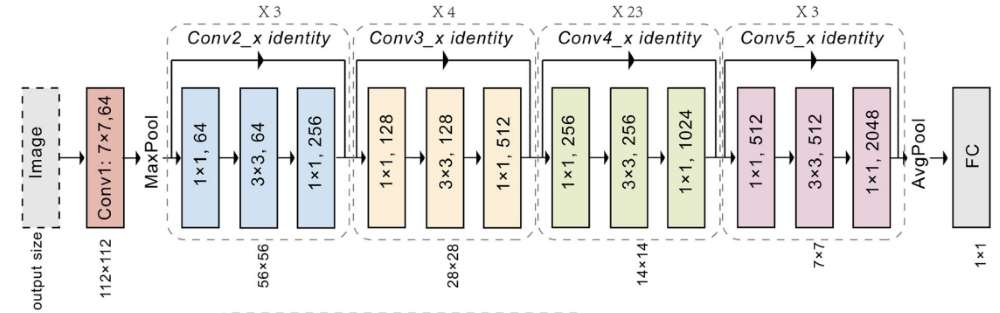

As we can see Resnet is composed of a set of blocks that repeat.
These blocks are in turn composed of subblocks composed of the same type of layers.

We can check the Resnet implementation in Pytorch [here](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py). Now we are going to take a look to the most relevant parts of the code:

### ResNet initialization

````
class Bottleneck(nn.Module):

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
````

Here we are doing the same that we have previously done in our network with:

````
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)
W1 = torch.randn(   (N_EMBD*BLOCK_SIZE, N_HIDDEN),  generator=g) * (5/3) * (1/np.sqrt(N_EMBD*BLOCK_SIZE))
W2 = torch.randn(   (N_HIDDEN, VOCABULARY_SIZE),    generator=g) * 0.01
b2 = torch.rand(    VOCABULARY_SIZE,                generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias = torch.zeros((1, N_HIDDEN))

bn_mean_running = torch.zeros((1, N_HIDDEN))
bn_std_running = torch.ones((1, N_HIDDEN))
````

We are basically creating the layers of the model.

### ResNet forward pass

```
    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
```

This forward pass take a input tensor `x` and then, sequentially the data goes through `conv`, `batchnorm` and `relu` layers.

This is the same that we have made in our code:
1. The input is first multiplied by a `W1` matrix (equivalent to the convolution operation)
2. Then we apply the batchnormalization steps (standardize the output values with `bn_mean_i` and `bn_std_i` and applying scale and shift with `bngain` and `bnbias` respectively)
3. Finally we pass the output through the activation layer `Tanh` in our case and `ReLu` in the ResNet.

There is another point that made our network similar to the ResNet (or at least similar to the building blocks of it). We have eliminated `b1` layer because it is useless if we apply the Batch Normalization later, in the same way when ResNet initialize the convolutional layer it does not include the bias component with the `bias=False` argument:
```
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
```

## How our layers compare to Pytorch layers

### Linear layer

The first layer that we are going to see in the pytorch `Linear` layer, this layer when take an input perform the same operation that we have performed with `W1` and `b1` or with `W2` and `b2`. So this:
```
output = x @ W1 + b1
```

is equivalent to this:
```
linear = torch.nn.Linear(input_size,output_size, bias=True)
output = linear(x)
```

There is some differences between our initialization values and the `Linear` initialization. While we initialize `W` and `b` using a normal distribution, `Linear` use a uniform distribution. But there is one, very important, similarity: when we initialize `W` we apply a gain calculated as `(5/3) * (1/np.sqrt(input_size))`, in the same way `Linear` is initialized as a Uniform distribution between $[\sqrt{-K}, \sqrt{K}]$, being $K = \frac{1}{input\_size}$ so basically pytorch apply the same gain as we have applied, the only difference is the `5/3` term, but we have applied it because we know that our activation function is `Tanh`, `Linear` layer does not have this information and do not apply this value. The gain that `Linear` apply is for the same reason that our gain, to maintain a roughly gaussian distribution we it recive gaussian distributed values as input.

### BatchNormalization layer

The equivalent in pytorch to the batchnormalization that we have applied in our network is the layer called [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html). Lets take a look to the param that this layer receives and how them compare to our parameters:
* *num_features*: is the number of elements that receives as input and it will determine the number of elements in `bngain`, `bnstd`, `bn_mean_running` and `bn_std_running` (all with same number of elements). In our implmemtation this param is equal to `N_HIDDEN`
* *eps*: the epsilon, *ε*, value previously explained, by default `1e-5`
* *momentum*: is the weight that we give to our current batch mean and std ie. `bn_mean_i` and `bn_std_i`, when they are used to calculate the running values. By default this param is equal to `0.1` but we can set a higher value if we are using a bigger batch size and therefore we trust a little bit more in the batch mean and std as representative of the entire dataset statistics.

## Pytorchify our previous code

The aim of this section is reformulate our code to make it more similar to the pytorch implementation. We will focus on three layers:
* The Linear layer
* The BatchNorm layer
* The Tanh activation layer

### Linear layer

In [11]:
g = torch.Generator().manual_seed(2147483647)

In [23]:
class Linear():

  def __init__(self, fan_in, fan_out, bias=True, apply_gain=True):
    # Weights initialized with Kaiming initialization
    self.weight = torch.randn((fan_in, fan_out), generator = g) / (fan_in**0.5 if apply_gain else 1.0)
    # Even we have defined bias as zero is more common to initialize them as 0s
    self.bias = torch.zeros((fan_out)) if bias else None


  def __call__(self, x):
    self.out = x.view(x.shape[0], -1) @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

### BatchNorm layer

In [20]:
class BatchNorm1d():

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    # This variable will be used to know when batchorm is trainig or infering
    # Batchnorm (as other layers) have a different behaviour when it is being
    # trained that when it is infering or being evaluated: in this case if
    # the layer is training it will use the batch mean and std and the running
    # statistics will be updated  but if it is infering or evaluating it will
    # use the running statistics and these statistics will not be updated
    self.training = True

    # Equivalent to bngain (Trained with backprop)
    self.gamma = torch.ones((1, dim))
    # Equivalent to bnbias (Trained with backprop)
    self.beta = torch.zeros((1, dim))

    # Equivalent to bn_mean_running (Trained with a 'running momentum' update)
    self.running_mean = torch.zeros((1, dim))
    # Equivalent to bn_std_running (Trained with a 'running momentum' update)
    self.running_var = torch.ones((1, dim))

  def __call__(self, x):
    if self.training:
      x_mean = x.mean(dim=0, keepdim=True)
      x_var = x.std(dim=0, keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
    self.out = self.gamma * x_hat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * x_var

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

## Tanh layer

In [21]:
class Tanh():

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

Now we can rebuild the neural network using the previously defined classes. We will start with a model without batch normalization:

In [22]:
N_EMBD = 10 # Number of dimensions in the embeddings
N_HIDDEN = 100 # Number of outputs of the first hidden layer


g = torch.Generator().manual_seed(2147483647)


C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)

layers = [
    Linear(fan_in = N_EMBD*BLOCK_SIZE, fan_out = N_HIDDEN), Tanh(),
    Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), Tanh(),
    Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), Tanh(),
    Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), Tanh(),
    Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), Tanh(),
    Linear(fan_in = N_HIDDEN, fan_out = VOCABULARY_SIZE)
]

# Now that we have initialized the layers lets apply the gains
with torch.no_grad():
  # First we apply the gain to the ouput layer to control the overconfidence in
  # wrong classes
  layers[-1].weight *= 0.1

  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      # If its a linear layer we apply the gain that fix the distribution in the
      # subsequente Tanh layer output
      layer.weight *= 5/3.0

# Build the list of parameters to optimize
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

# Number of elements in the model
print(f"Number of params: {sum([p.numel() for p in parameters])}")

Number of params: 46497


In [15]:
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):

  samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

  Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

  x = C[Xb]

  # Here we use the list of layers to pass the value for all of them in a loop
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if step < 100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad


  if step % 10000 == 0:
    print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

  lossi.append(loss.log10().item())

  break

NameError: name 'Ytr' is not defined

## Tanh output values analysis

Lets compare the ouput distribution for the Tanh values when we apply `5/3` vs when we do not apply gain. We are going to define a function that encapsulate the definition and train during one epoch and receive as param the gain that we are going to apply. We are doing this to not copy and paste every time the network:

In [26]:
 def get_layers_with_Tanh_gain(gain, include_tanh_layers=True, optimization_steps = 1, initial_learning_rate=0.001, apply_good_gain=True):
  N_EMBD = 10 # Number of dimensions in the embeddings
  N_HIDDEN = 100 # Number of outputs of the first hidden layer


  g = torch.Generator().manual_seed(2147483647)


  C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)

  if include_tanh_layers:

    layers = [
        Linear(fan_in = N_EMBD*BLOCK_SIZE, fan_out = N_HIDDEN, apply_gain=apply_good_gain), Tanh(),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN, apply_gain=apply_good_gain), Tanh(),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN, apply_gain=apply_good_gain), Tanh(),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN, apply_gain=apply_good_gain), Tanh(),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN, apply_gain=apply_good_gain), Tanh(),
        Linear(fan_in = N_HIDDEN, fan_out = VOCABULARY_SIZE)
    ]
  else:

    layers = [
        Linear(fan_in = N_EMBD*BLOCK_SIZE, fan_out = N_HIDDEN),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN),
        Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN),
        Linear(fan_in = N_HIDDEN, fan_out = VOCABULARY_SIZE)
    ]
  # Now that we have initialized the layers lets apply the gains
  with torch.no_grad():
    # First we apply the gain to the ouput layer to control the overconfidence in
    # wrong classes
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
      if isinstance(layer, Linear):
        # If its a linear layer we apply the gain that fix the distribution in the
        # subsequente Tanh layer output
        layer.weight *= gain

  # Build the list of parameters to optimize
  parameters = [C] + [p for layer in layers for p in layer.parameters()]
  for p in parameters:
    p.requires_grad = True

  # Number of elements in the model
  print(f"Number of params: {sum([p.numel() for p in parameters])}")

  max_steps = 200000
  batch_size = 32
  lossi = []
  update_to_data_ratios = []

  for step in range(max_steps):

    samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

    Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

    x = C[Xb]

    # Here we use the list of layers to pass the value for all of them in a loop
    for layer in layers:
      x = layer(x)

    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
      # We use this to keep the gradients of the ouput
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

    for p in parameters:
      p.grad = None

    loss.backward()

    lr = initial_learning_rate if step < 100000 else 0.01
    for p in parameters:
      p.data += -lr*p.grad


    if step % 10000 == 0:
      print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
      update_to_data_ratios.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if step == optimization_steps-1:
      print(step)
      break

  return layers, parameters, update_to_data_ratios

Number of params: 46497
      0/ 200000: 3.293301
0
layer 1 (      Tanh): mean -0.01, std 0.75, saturated: 17.72%
layer 3 (      Tanh): mean +0.05, std 0.68, saturated: 8.81%
layer 5 (      Tanh): mean +0.02, std 0.67, saturated: 6.00%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.62%
layer 9 (      Tanh): mean -0.03, std 0.66, saturated: 5.94%


Text(0.5, 1.0, 'activation distribution')

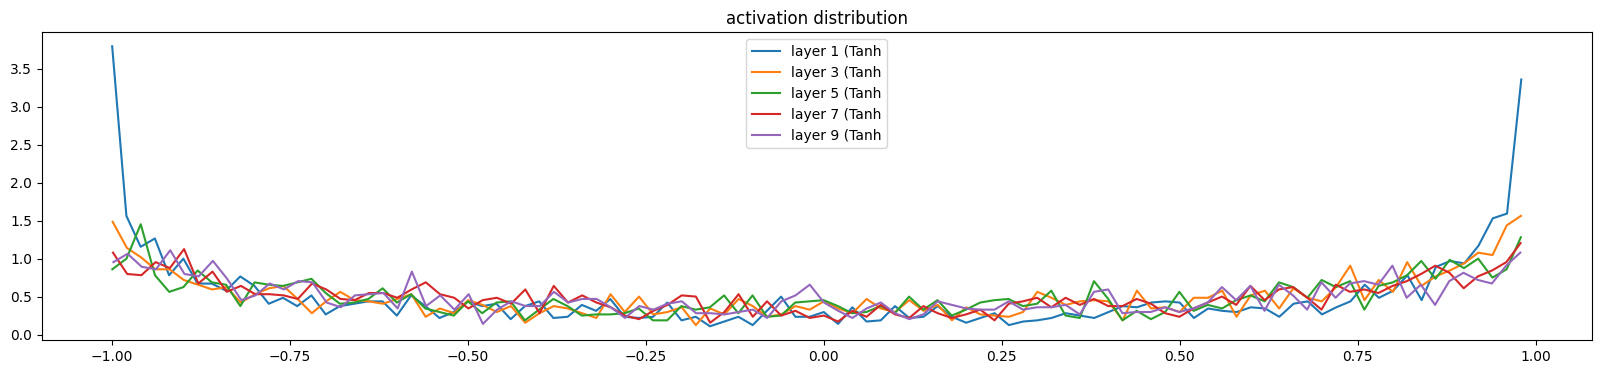

In [110]:
layers,_,_ = get_layers_with_Tanh_gain(5/3.0)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

As we can see in the previous plot when we apply the gain the number of saturated values is relatively low, it start at `20%` in the first layer but it stabilize to less than `10%` in the subsequent Tanh ouputs. Another good point here is that the standard deviation seems quite good, we do not have the ideal `1` but it is this `0.6` are ok.

Lets now see what happens when we do not apply this gain:

Number of params: 46497
      0/ 200000: 3.294127
0
layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.16%
layer 3 (      Tanh): mean -0.01, std 0.48, saturated: 0.25%
layer 5 (      Tanh): mean +0.02, std 0.41, saturated: 0.03%
layer 7 (      Tanh): mean +0.00, std 0.38, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.33, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

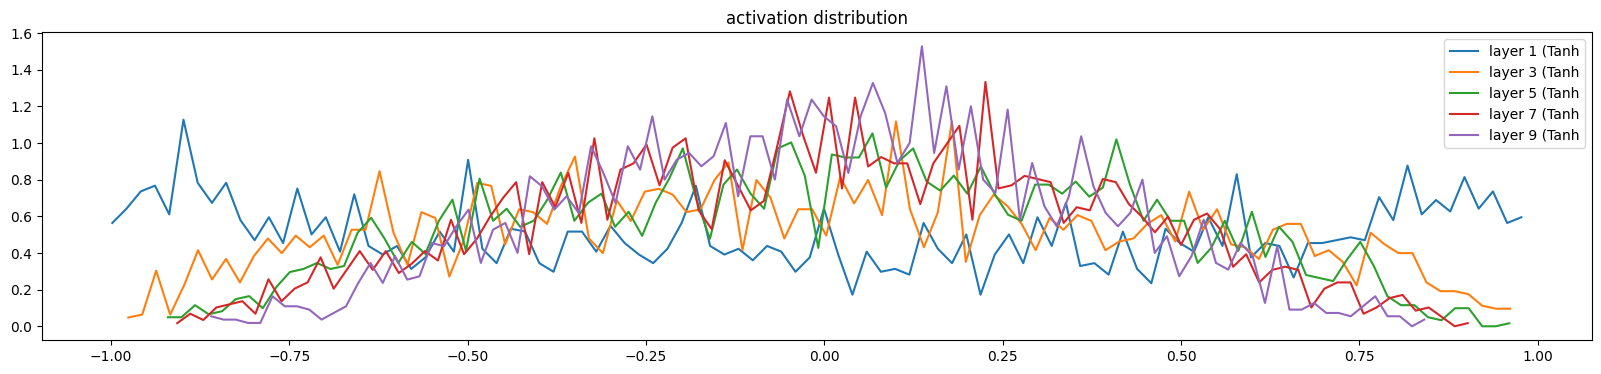

In [112]:
layers,_,_ = get_layers_with_Tanh_gain(1.0)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

As we can see in the previous plot we do not have the issue of the saturated values here which is good, but something worst is happening. Because our values passes one after another layers of Tanh every time the values squashes a little bit more and we can see the consequences in the standard deviation. Our data is being packed a little bit after each layers: we start with a `0.62`std and in the last layer std is `0.32`. The problem here is that if we had even more layers the data would continue to be compressed. This situation did not occur when we used the gain in the previous model, the standard deviation stabilized in the last layers.

The explanation for this is that since the Tanh function is a function that compresses (squashes) the values we need to apply a gain to the values ​​to expand this values again.

In the other hand if the gain is too high we will have also problems, for example the next distribution is created using a gain of `3`:

Number of params: 46497
      0/ 200000: 3.315357
0
layer 1 (      Tanh): mean +0.05, std 0.86, saturated: 48.22%
layer 3 (      Tanh): mean +0.04, std 0.84, saturated: 40.84%
layer 5 (      Tanh): mean -0.00, std 0.83, saturated: 38.66%
layer 7 (      Tanh): mean -0.03, std 0.83, saturated: 40.56%
layer 9 (      Tanh): mean -0.00, std 0.83, saturated: 39.50%


Text(0.5, 1.0, 'activation distribution')

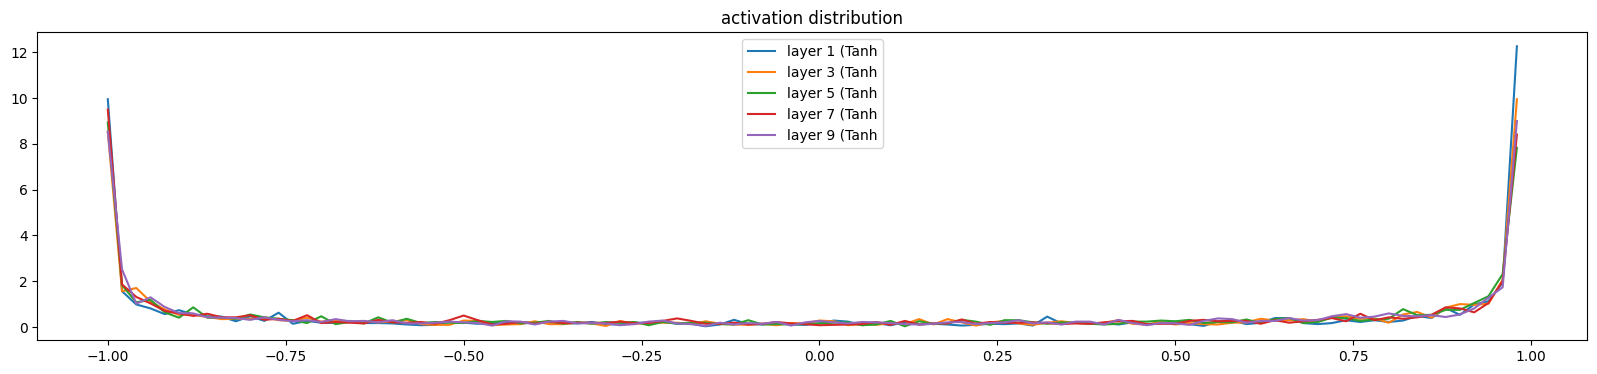

In [113]:
layers,_,_ = get_layers_with_Tanh_gain(3.0)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

We can see here that this gain of `3` improves our std which is great, but in exchange, the percentage of saturated values ​​has increased a lot and practically half of the output values ​​are saturated, which is a serious problem for the correct training of the network.

Now lets analyze the gradients

Number of params: 46497
      0/ 200000: 3.326830
0
layer 1 (      Tanh): mean +0.000004, std 4.149762e-04
layer 3 (      Tanh): mean +0.000000, std 4.060685e-04
layer 5 (      Tanh): mean -0.000004, std 3.893378e-04
layer 7 (      Tanh): mean +0.000013, std 3.492231e-04
layer 9 (      Tanh): mean +0.000016, std 3.108520e-04


Text(0.5, 1.0, 'gradient distribution')

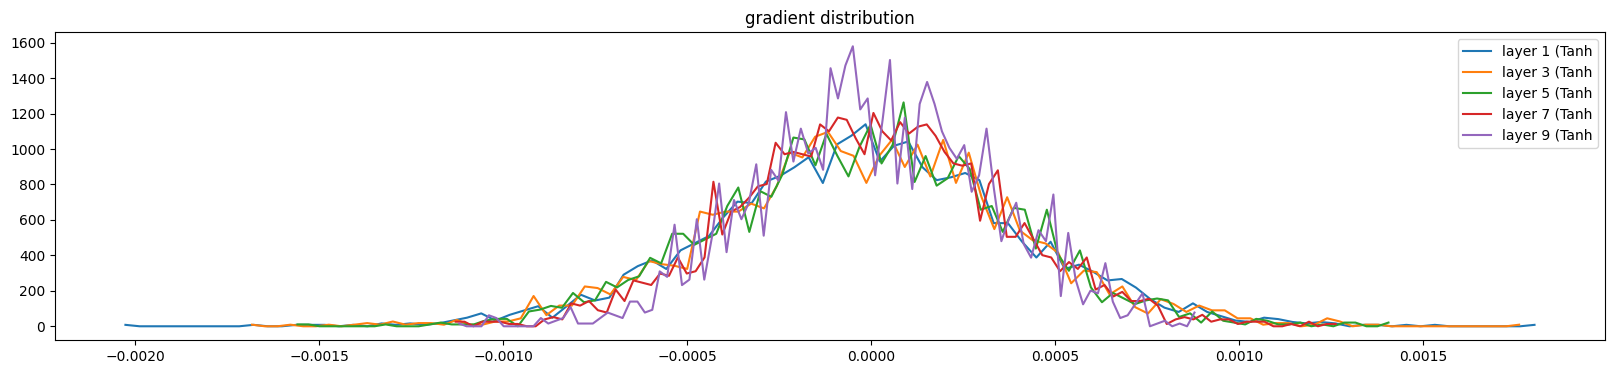

In [114]:
layers,_,_ = get_layers_with_Tanh_gain(5/3.0)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Again, the `5/3` gain gives us a good behaviour in the gradients. The gradients across different subsequents layers keeps the same distribution. They are not shrinking or exploding wich is a undesirable effect. Even as we see that on each layer the std make a little bit smaller the rate of change `1e-4` is small enough to be acceptable. Let see now what happens if we use a smaller gain like `0.5`:

Number of params: 46497
      0/ 200000: 3.296241
0
layer 1 (      Tanh): mean -0.000000, std 1.862591e-05
layer 3 (      Tanh): mean +0.000001, std 3.841653e-05
layer 5 (      Tanh): mean -0.000004, std 7.966065e-05
layer 7 (      Tanh): mean +0.000004, std 1.510465e-04
layer 9 (      Tanh): mean +0.000000, std 3.129988e-04


Text(0.5, 1.0, 'gradient distribution')

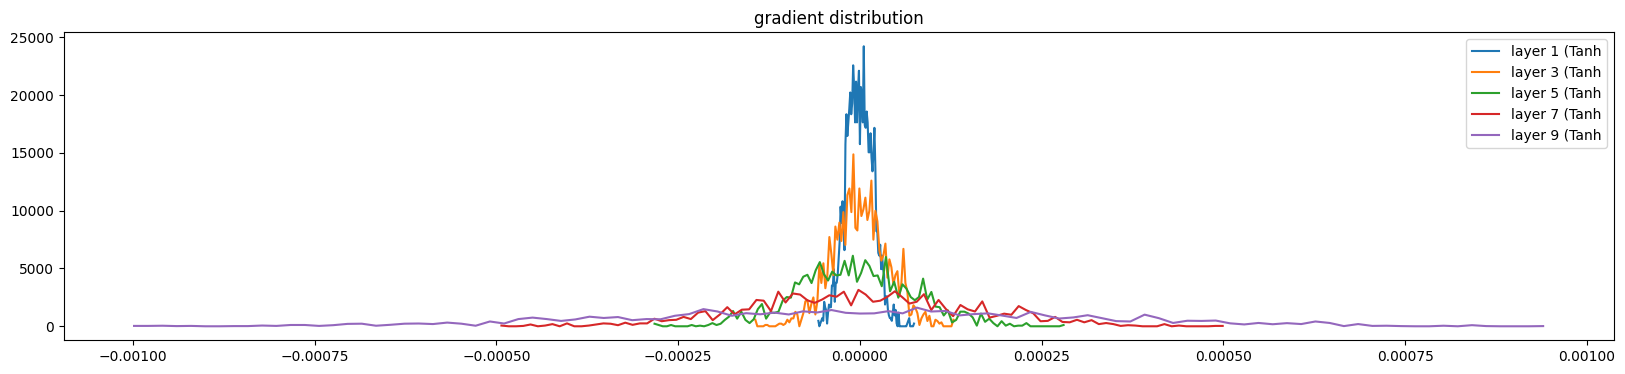

In [115]:
layers,_,_ = get_layers_with_Tanh_gain(0.5)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

As we can see the std of the gradients starts to expand after every layer: it starts with `1.8e-5`, then `3.8e-5`, then `7.1e-5`, then `1.5e-4` and finally `2.9e-4`. This is a bad thing because we are interested in get stable behaviours. We need this stability specially when we work with much bigger networks.

In the other hand if we use a much bigger gain like `3`:

Number of params: 46497
      0/ 200000: 3.288532
0
layer 1 (      Tanh): mean -0.000004, std 1.019327e-03
layer 3 (      Tanh): mean -0.000002, std 7.331201e-04
layer 5 (      Tanh): mean -0.000013, std 5.551137e-04
layer 7 (      Tanh): mean +0.000000, std 4.051173e-04
layer 9 (      Tanh): mean -0.000010, std 3.063076e-04


Text(0.5, 1.0, 'gradient distribution')

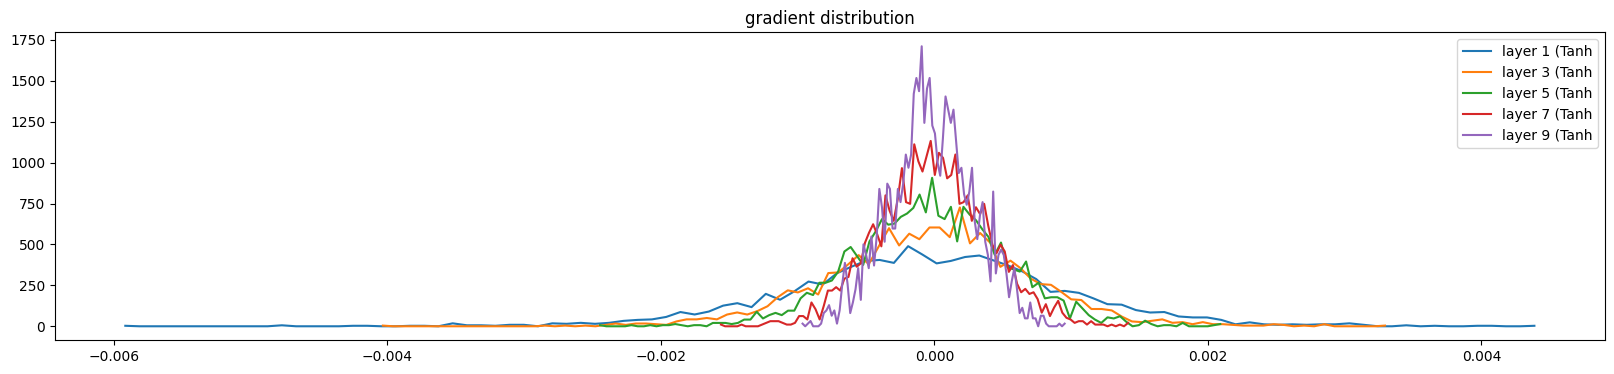

In [116]:
layers,_,_ = get_layers_with_Tanh_gain(3.0)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Here we have the inverse effect, the distribution std is making smaller after each layer. It seems that again the correct gain is `5/3`.

As we have seen before this values, `5/3` is because the presence of Tanh activations. Let see what happens if we only have linear layers:


Number of params: 46497
      0/ 200000: 3.834199
0
layer 0 (    Linear): mean -0.08, std 1.58, saturated: 52.97%
layer 1 (    Linear): mean -0.05, std 2.73, saturated: 72.34%
layer 2 (    Linear): mean +0.15, std 4.76, saturated: 85.50%
layer 3 (    Linear): mean -0.03, std 7.98, saturated: 90.59%
layer 4 (    Linear): mean +1.41, std 13.20, saturated: 93.50%


Text(0.5, 1.0, 'activation distribution')

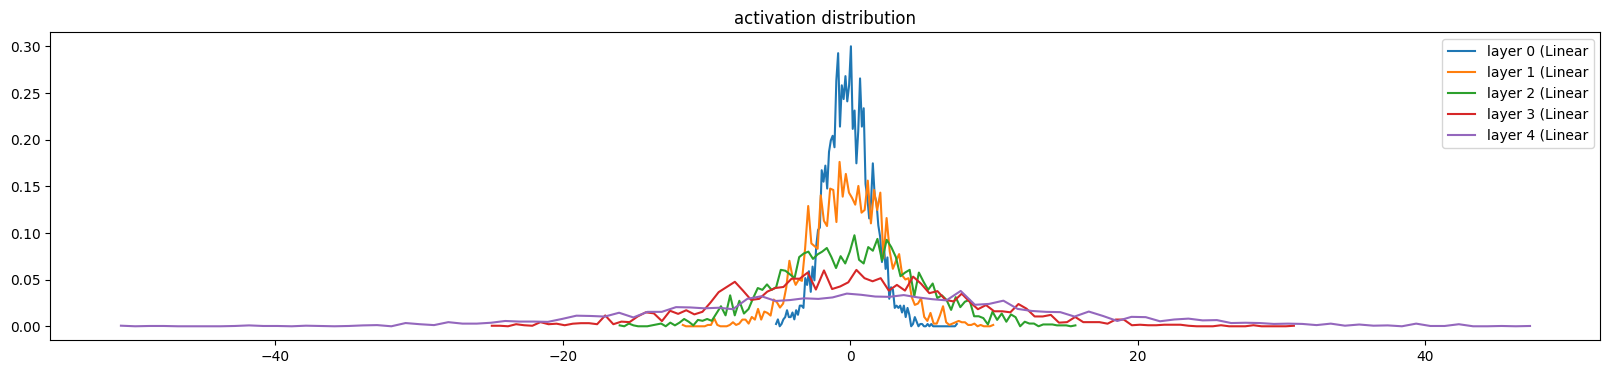

In [117]:
layers,_,_ = get_layers_with_Tanh_gain(5/3.0, include_tanh_layers=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

The distribution of the activations starts to diffuss, or expand progresively after each layer. We will see the inverse behaviour in the gradients:

Number of params: 46497
      0/ 200000: 4.442616
0
layer 0 (    Linear): mean -0.000137, std 2.612030e-03
layer 1 (    Linear): mean -0.000057, std 1.526701e-03
layer 2 (    Linear): mean +0.000016, std 8.962556e-04
layer 3 (    Linear): mean +0.000002, std 5.428962e-04
layer 4 (    Linear): mean -0.000009, std 3.268844e-04


Text(0.5, 1.0, 'gradient distribution')

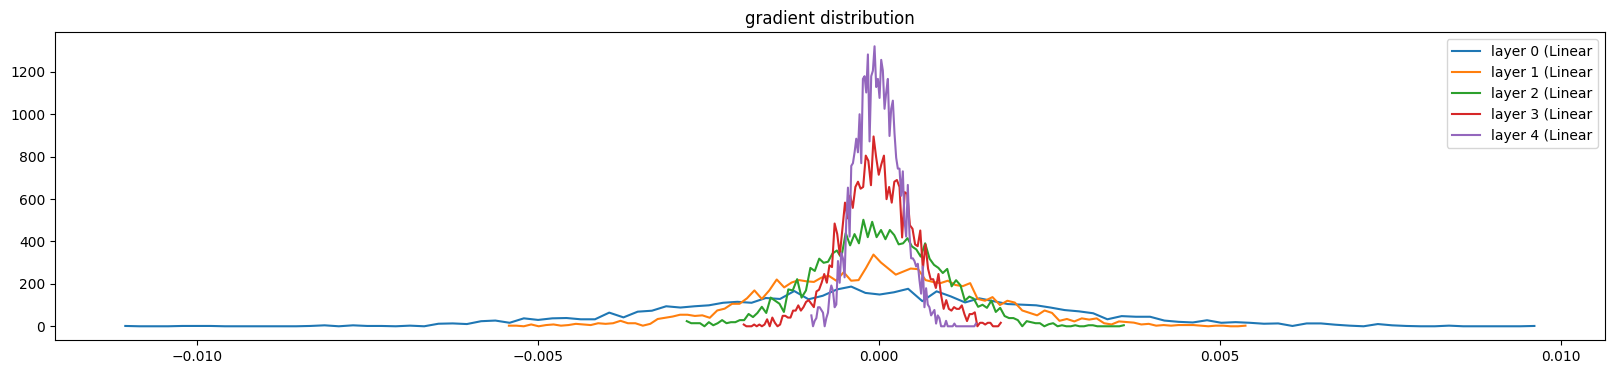

In [118]:
layers,_,_ = get_layers_with_Tanh_gain(5/3.0, include_tanh_layers=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

As we expect the gradient expand from the ouput to the input. As we have said previously this is not he behavioir that we want. It happens now because we have removed the Tanh layers from the models, so now the correct gain is `1.0`:

Number of params: 46497
      0/ 200000: 3.301775
0
layer 0 (    Linear): mean +0.01, std 0.99, saturated: 33.34%
layer 1 (    Linear): mean +0.01, std 0.99, saturated: 32.38%
layer 2 (    Linear): mean -0.02, std 0.98, saturated: 30.91%
layer 3 (    Linear): mean -0.01, std 0.99, saturated: 30.31%
layer 4 (    Linear): mean -0.00, std 1.00, saturated: 33.19%


Text(0.5, 1.0, 'activation distribution')

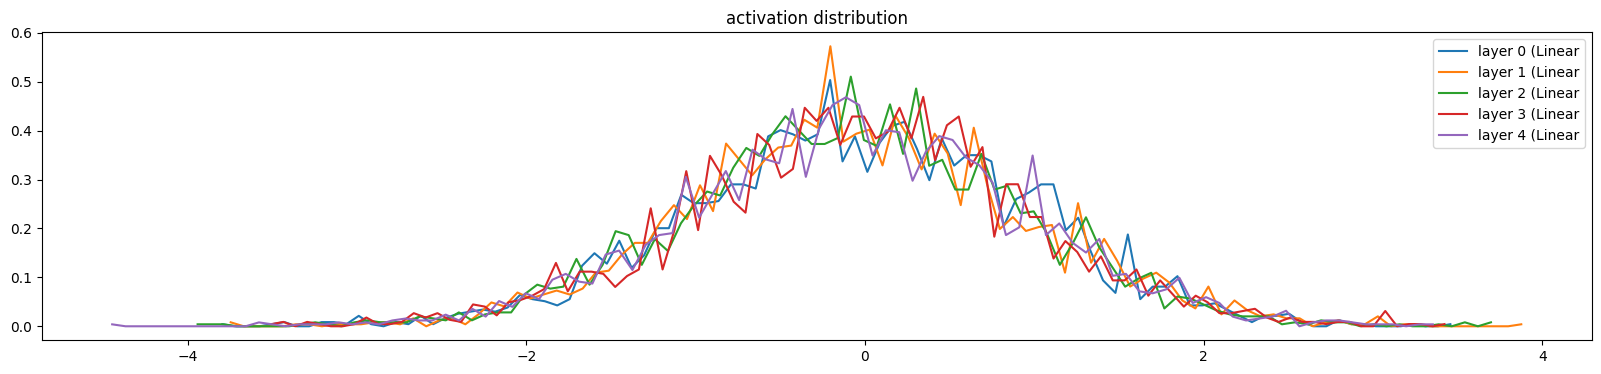

In [119]:
layers,_,_ = get_layers_with_Tanh_gain(1.0, include_tanh_layers=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Number of params: 46497
      0/ 200000: 3.284279
0
layer 0 (    Linear): mean +0.000012, std 3.169444e-04
layer 1 (    Linear): mean -0.000005, std 3.356847e-04
layer 2 (    Linear): mean +0.000022, std 3.264443e-04
layer 3 (    Linear): mean +0.000011, std 3.224084e-04
layer 4 (    Linear): mean -0.000005, std 3.114302e-04


Text(0.5, 1.0, 'gradient distribution')

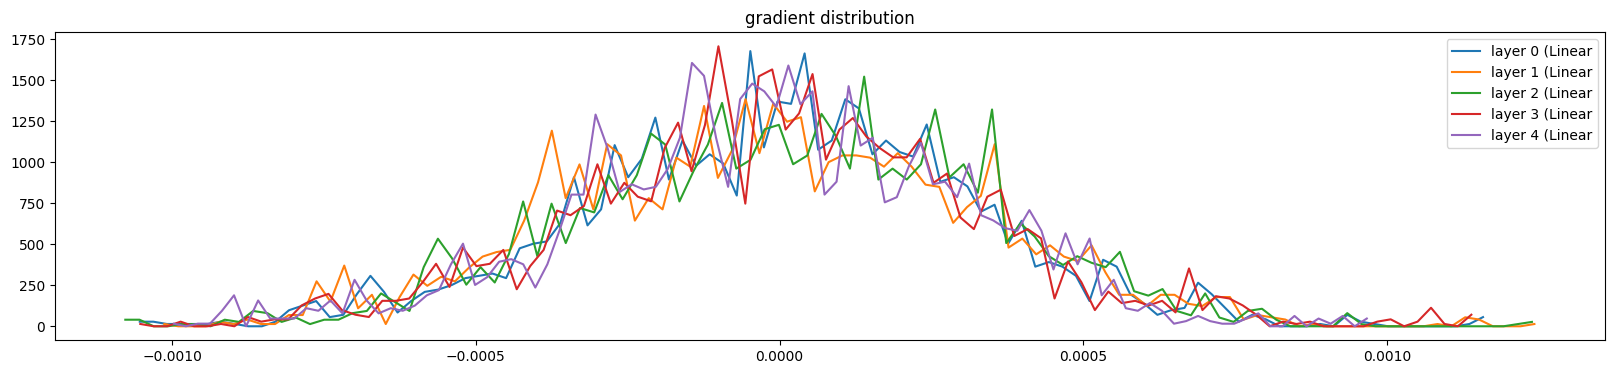

In [120]:
layers,_,_ = get_layers_with_Tanh_gain(1.0, include_tanh_layers=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

We see that in we remove the Tanh functions the correct gain is `1.0` is the value that keeps the distributions stables across all the layers.

Following this line of thoughts we can see that with a very small gain we have also problems with the activations and gradients distributions and how they evolve across layers.

Number of params: 46497
      0/ 200000: 3.295879
0
layer 0 (    Linear): mean +0.000000, std 2.569205e-06
layer 1 (    Linear): mean -0.000000, std 8.268116e-06
layer 2 (    Linear): mean +0.000000, std 2.750887e-05
layer 3 (    Linear): mean +0.000005, std 9.049640e-05
layer 4 (    Linear): mean +0.000003, std 3.009824e-04


Text(0.5, 1.0, 'gradient distribution')

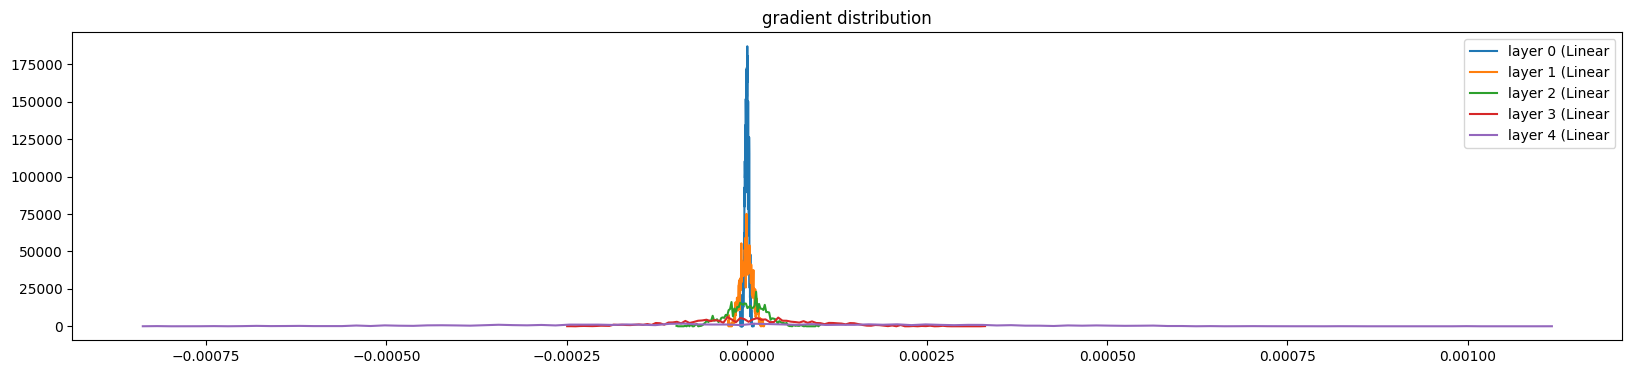

In [121]:
layers,_,_ = get_layers_with_Tanh_gain(0.3, include_tanh_layers=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Number of params: 46497
      0/ 200000: 3.295867
0
layer 0 (    Linear): mean +0.01, std 0.29, saturated: 0.03%
layer 1 (    Linear): mean +0.00, std 0.08, saturated: 0.00%
layer 2 (    Linear): mean -0.00, std 0.02, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.01, saturated: 0.00%
layer 4 (    Linear): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

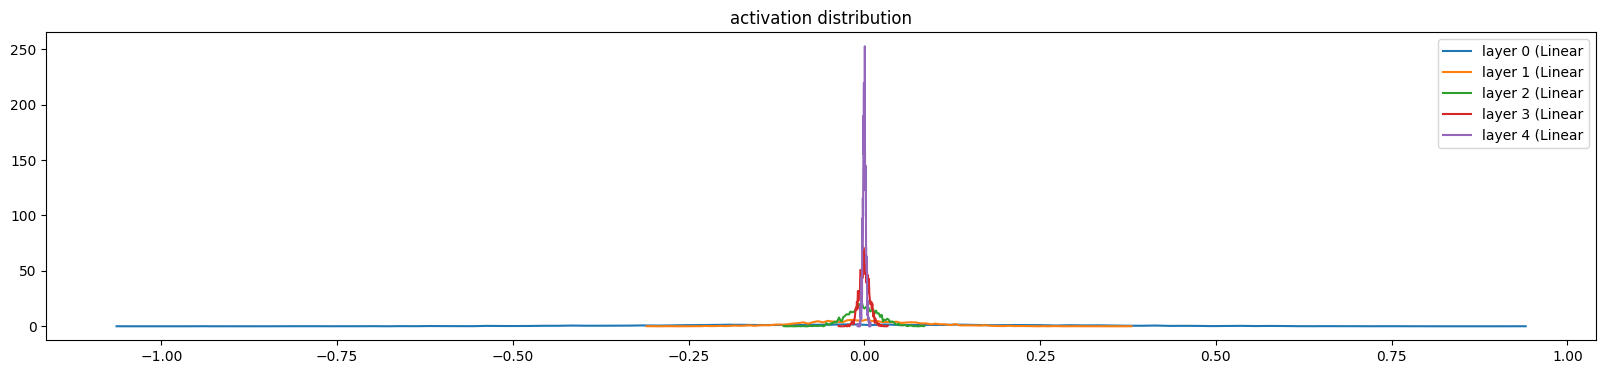

In [122]:
layers,_,_ = get_layers_with_Tanh_gain(0.3, include_tanh_layers=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

The important point to remember here is the following:

*We need to choose gains that keep the distirbutions stables across all the layers*

There is another thing to maybe look for it other day and that is that with a gain bigger than the optimal one the gradients distribution is greater in input layer that in the last layers and the inverse situation in the activation distributions.

In the other hand a gain smaller than the optimal one we have a inverse situation.

But as i say previously the key point is get stable distributions.

### Analyzing updates to data ratios

Now we are going to analize how the weights of the two dimensional parameters ie. the parameter of the weights (the parameters that multiply inputs)

Number of params: 46497
      0/ 200000: 3.300730
0
weight   (27, 10) | mean +0.000000 | std 1.090830e-03 | grad:data ratio 1.090040e-03
weight  (30, 100) | mean +0.000006 | std 1.086424e-03 | grad:data ratio 3.624623e-03
weight (100, 100) | mean +0.000002 | std 9.910435e-04 | grad:data ratio 6.025705e-03
weight (100, 100) | mean -0.000026 | std 9.802759e-04 | grad:data ratio 5.901312e-03
weight (100, 100) | mean +0.000001 | std 8.900129e-04 | grad:data ratio 5.391482e-03
weight (100, 100) | mean +0.000010 | std 8.049500e-04 | grad:data ratio 4.859713e-03
weight  (100, 27) | mean -0.000000 | std 2.261372e-02 | grad:data ratio 2.204748e+00


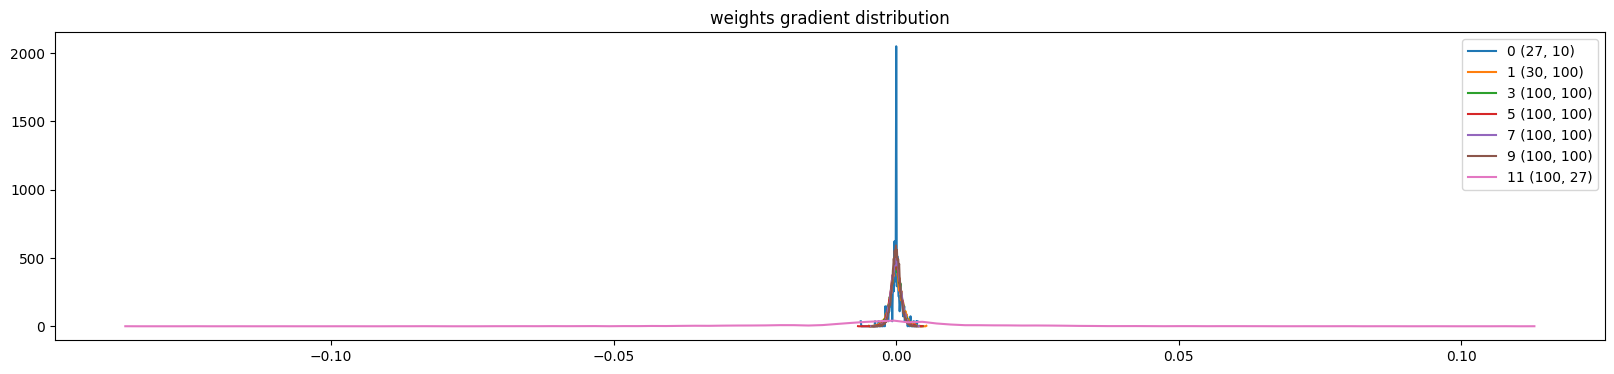

In [123]:
layers,parameters,_ = get_layers_with_Tanh_gain(5/3.0, include_tanh_layers=True)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

We can see that something weird is happenning with the weights distribition of the last layer, we will see it in a moment.

First we can see that a new metric called `grad:data ratio` has been added. This metric represent the ratio between the weigths and the gradient that are applied to them (without taking into account the Learnig rate). This metric is going to give us a sense about what is the scale of the gradients compares to the scale ​​to which it is applied (the weights).

We can see that except for the last layer the values of the weights are `1000`bigger than the values of the gradients.

Coming back to the last layer we can see that the std value of the gradients is almost `10` times bigger in the last layer compared with the rest of them. This is going to be a problem because that means that this layer is going to be modified (trained) `10` times faster that the other layers, at least in the initialization.

In any case our small network can stabilize the `grad:data ratio` for the last layers if we let it be trained during more steps:

Number of params: 46497
      0/ 200000: 3.305582
999
weight   (27, 10) | mean -0.000729 | std 7.978810e-03 | grad:data ratio 7.970616e-03
weight  (30, 100) | mean -0.000090 | std 8.901822e-03 | grad:data ratio 2.945242e-02
weight (100, 100) | mean -0.000070 | std 7.031335e-03 | grad:data ratio 4.193739e-02
weight (100, 100) | mean -0.000030 | std 6.528159e-03 | grad:data ratio 3.827085e-02
weight (100, 100) | mean -0.000023 | std 6.453609e-03 | grad:data ratio 3.865739e-02
weight (100, 100) | mean +0.000013 | std 5.597891e-03 | grad:data ratio 3.351875e-02
weight  (100, 27) | mean -0.000000 | std 2.192702e-02 | grad:data ratio 3.138225e-01


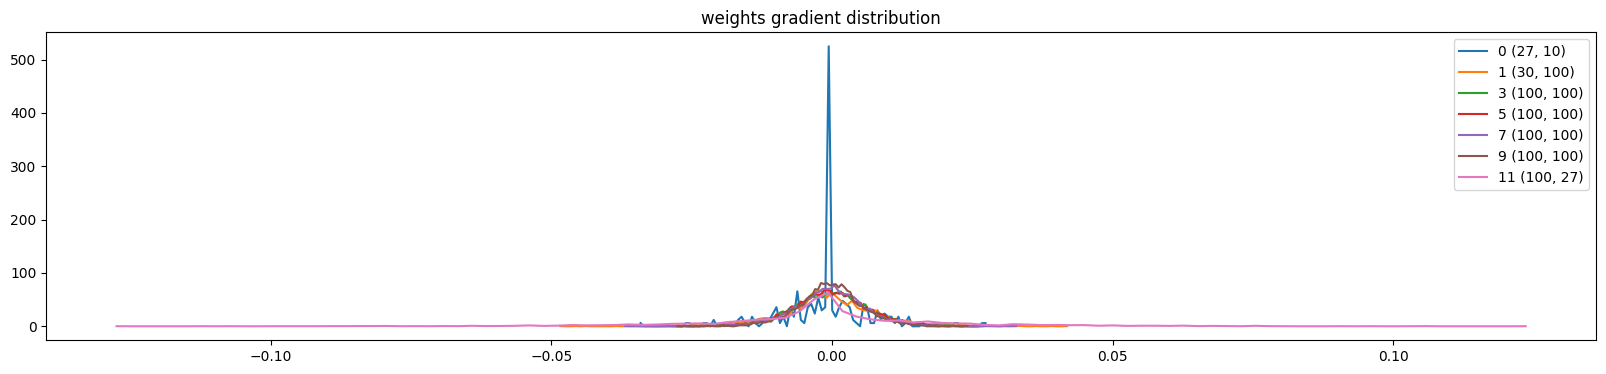

In [124]:
layers, parameters, _ = get_layers_with_Tanh_gain(5/3.0, include_tanh_layers=True, optimization_steps=1000)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

We can see that the std of the gradients of all layers has made a little bit bigger coming closer to the std of the last layer. And the grad:data ratio for the last layer is now smaller than previously. So the train has been able to stabilize the initial situation, probably because we are working with a very simple and small network.

But there is yet another important metric or values to monitorize, this is the update to data ratio, similar to the grad to data ratio, but this new one takes into account the learning rate and therefore explore the real value that is applied to the weights (the real value that is added to the weights during the optimization steps)

Number of params: 46497
      0/ 200000: 3.286866
999


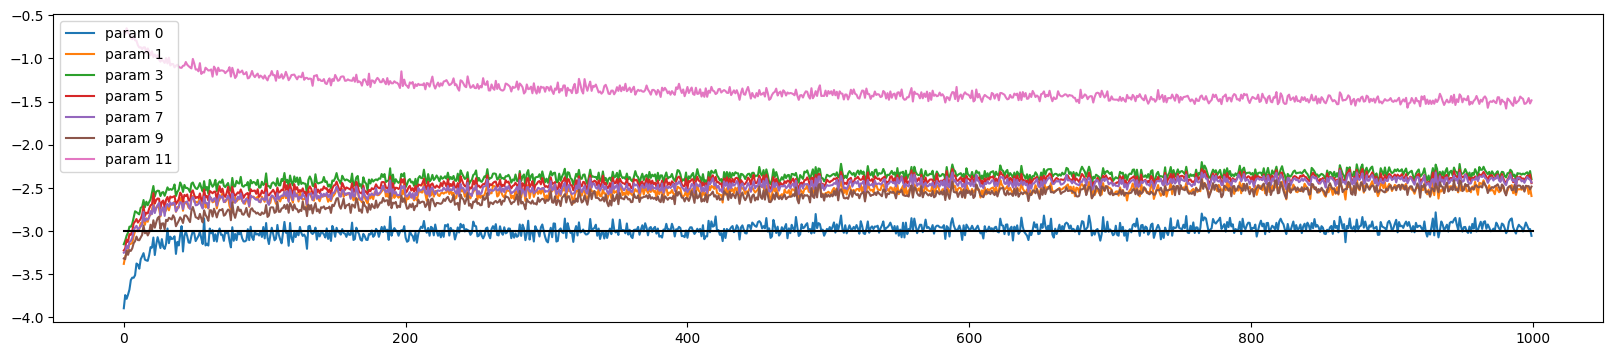

In [17]:
layers, parameters, ud = get_layers_with_Tanh_gain(5/3.0, include_tanh_layers=True, optimization_steps=1000)

#
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The previous plots show in logarithmic scale the update to data ratio, the black line show a ratio that usually is taken as desirable, as we can see this line is placed at `y=-3`, because we are in logarithm scale it means 0.001 ie. ideally the scale of the updates should be `1000` times smaller than the values (weights) scale. As we can see we achieve the desired ratio in the first layer and close values in the rest of the layers except for the final one.

The reason for this last layer having a bigger update ratio is the following line of code:
```
layers[-1].weight *= 0.1
```

In the intialization of the last layer we are artificially shrinking the weights (multipying it by 0.1) to keep the softmax unconfident (reduce the logits values to later reduce the initial loss), this made the weights smaller and the the update to data ratio increase.

We should take care that the update to data ratio do not fall below this `-3` threshold, smaller values could mean that the updates are too much small and this situation is going to cause that our weights do not learn fast enough.

We can force this situation if we use a very small learning rate as we can see in the next plot:

Number of params: 46497
      0/ 200000: 3.288036
999


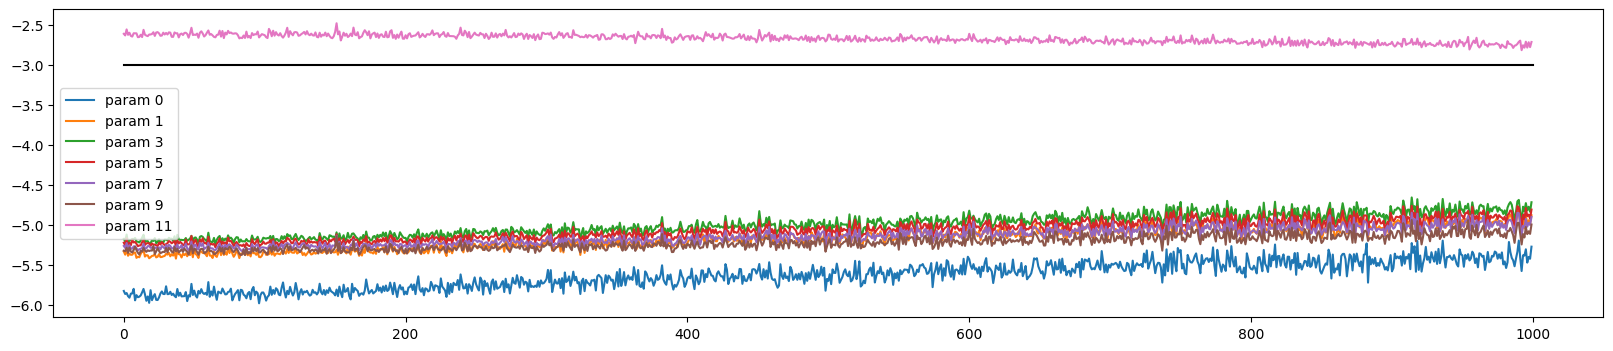

In [19]:
layers, parameters, ud = get_layers_with_Tanh_gain(5/3.0, include_tanh_layers=True, optimization_steps=1000, initial_learning_rate=0.001)

#
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

## Misscalibrating the neural network

Now that we have seen how to make that all work well in terms of distributions of activations, gradients, gradients to data ratio and update to data ratio lets make a simple small change to see what happens when all in misscalibrated. In this case we are going to remove the gain in the Linear layer, the one that we've added to ensure the gaussian distribution in the output of the layer

Number of params: 46497
      0/ 200000: 3.312080
0
layer 1 (      Tanh): mean -0.01, std 0.96, saturated: 81.78%
layer 3 (      Tanh): mean +0.04, std 0.97, saturated: 89.97%
layer 5 (      Tanh): mean +0.03, std 0.97, saturated: 88.66%
layer 7 (      Tanh): mean +0.01, std 0.97, saturated: 89.09%
layer 9 (      Tanh): mean -0.01, std 0.98, saturated: 90.44%


Text(0.5, 1.0, 'activation distribution')

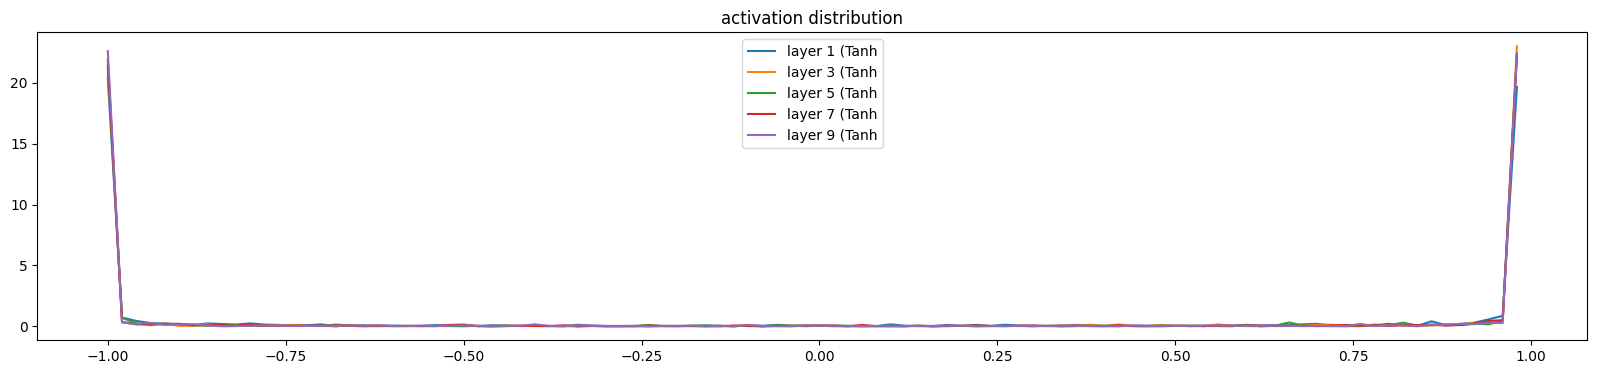

In [27]:
layers,_,_ = get_layers_with_Tanh_gain(gain=5/3.0, apply_good_gain=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

We can see that almost all of the values are saturated in the output of the Tanh layers, that's because the  desviation in the ouput of the linear layer is higher than before (because we are not apply anymore the gain `1/(fan_in**0.5)` therefore taking higher absolute values.

Number of params: 46497
      0/ 200000: 3.304159
0
layer 0 (    Linear): mean -0.000015, std 5.359346e-03
layer 2 (    Linear): mean -0.000004, std 1.151679e-03
layer 4 (    Linear): mean +0.000006, std 3.788647e-04
layer 6 (    Linear): mean -0.000002, std 1.532939e-04
layer 8 (    Linear): mean +0.000000, std 5.569477e-05


Text(0.5, 1.0, 'gradient distribution')

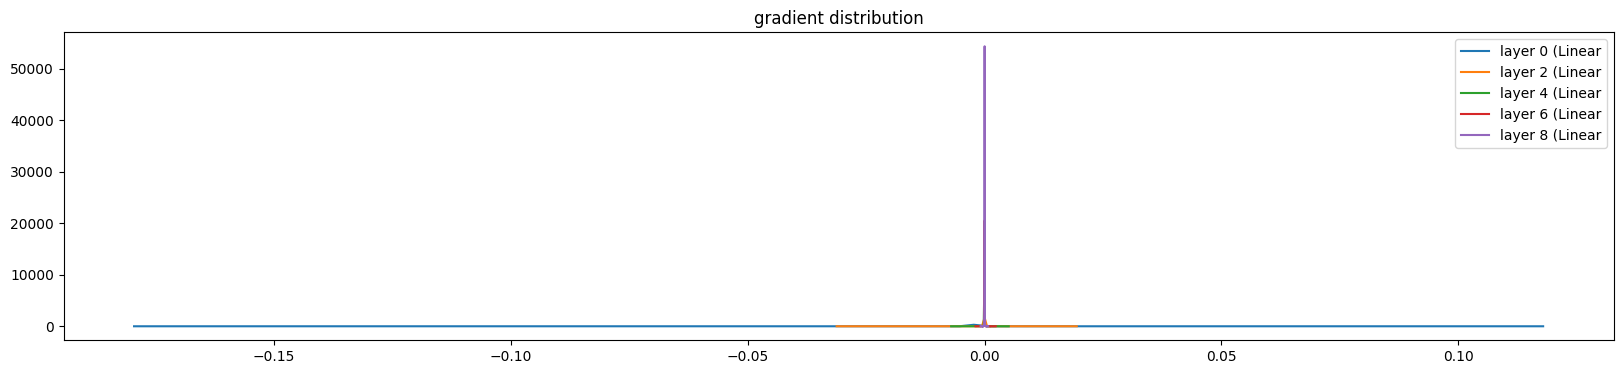

In [28]:
layers,_,_ = get_layers_with_Tanh_gain(gain=5/3.0, apply_good_gain=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Number of params: 46497
      0/ 200000: 3.297391
0
weight   (27, 10) | mean +0.022213 | std 2.286114e-01 | grad:data ratio 2.284461e-01
weight  (30, 100) | mean +0.000655 | std 4.271527e-02 | grad:data ratio 2.561498e-02
weight (100, 100) | mean -0.000106 | std 9.760964e-03 | grad:data ratio 5.855179e-03
weight (100, 100) | mean -0.000023 | std 3.066540e-03 | grad:data ratio 1.833199e-03
weight (100, 100) | mean -0.000002 | std 8.930806e-04 | grad:data ratio 5.361729e-04
weight (100, 100) | mean +0.000000 | std 3.337527e-04 | grad:data ratio 2.018332e-04
weight  (100, 27) | mean +0.000000 | std 3.181139e-02 | grad:data ratio 3.111396e+00


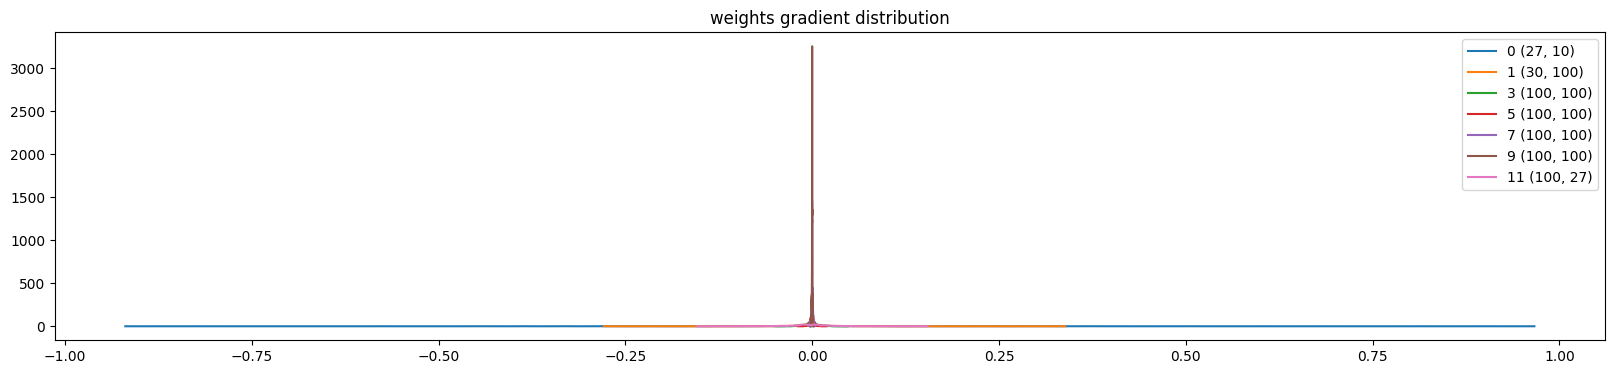

In [30]:
layers, parameters, _ = get_layers_with_Tanh_gain(gain=5/3.0, apply_good_gain=False)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Number of params: 46497
      0/ 200000: 3.343624
999


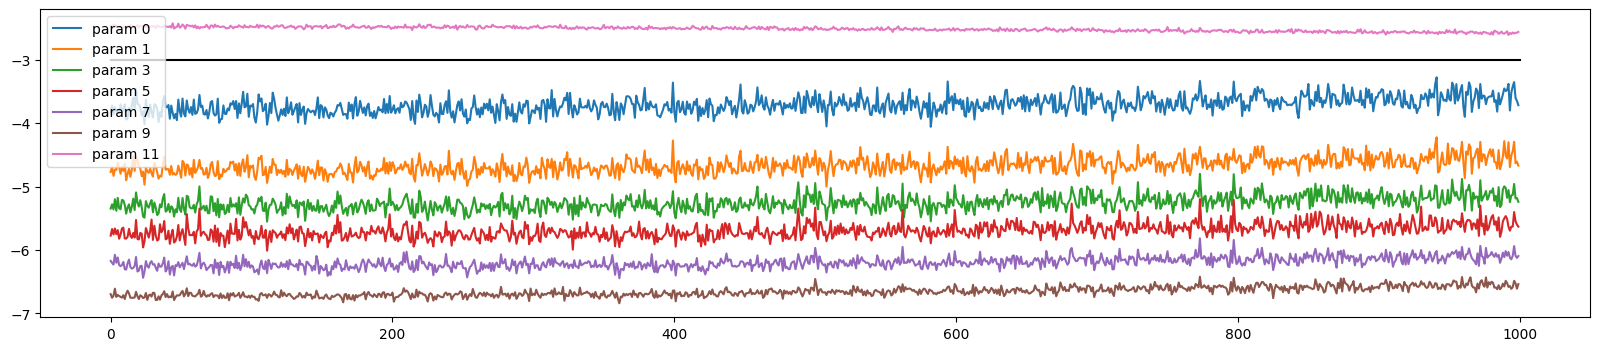

In [33]:
layers, parameters, ud = get_layers_with_Tanh_gain(gain=5/3.0, optimization_steps=1000, apply_good_gain=False)

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

As we have seen the gradients, the values and the data are not going to be uniforms, we can find great differences in this values among the layers. We can find differences of many orders of magnitud, specially in the standard deviation.

We can also see a bad situation in the update to data ratio with almost all of the layers (except for the last one) below the `0.001` (`-3` in log scale) so these layers are going to learn too slowly.

## Using BatchNormalization

As we have seen our network is very sensible to the changes in gain and other parameters. Lets now introduce batchnormalization layers in our network to see if we can improve this situation. We are going to change the model in the following ways:
* We are going to include the BatchNorm1d layer after the Linears
* Now the gain that we apply previosuly to the weights of the output to make the network less confident in the firts iteration is going to be applied to the last batchnorm gamma instead (to achieve the same effect, because now the final layer is this BatchNorm)

In [38]:
 def get_layers_with_BatchNorm_gain(gain, optimization_steps = 1):
  N_EMBD = 10 # Number of dimensions in the embeddings
  N_HIDDEN = 100 # Number of outputs of the first hidden layer


  g = torch.Generator().manual_seed(2147483647)


  C = torch.randn(    (VOCABULARY_SIZE, N_EMBD),      generator=g)


  layers = [
      Linear(fan_in = N_EMBD*BLOCK_SIZE, fan_out = N_HIDDEN), BatchNorm1d(dim=N_HIDDEN), Tanh(),
      Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), BatchNorm1d(dim=N_HIDDEN), Tanh(),
      Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), BatchNorm1d(dim=N_HIDDEN), Tanh(),
      Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), BatchNorm1d(dim=N_HIDDEN), Tanh(),
      Linear(fan_in = N_HIDDEN, fan_out = N_HIDDEN), BatchNorm1d(dim=N_HIDDEN), Tanh(),
      Linear(fan_in = N_HIDDEN, fan_out = VOCABULARY_SIZE), BatchNorm1d(dim=VOCABULARY_SIZE),
  ]

  # Now that we have initialized the layers lets apply the gains
  with torch.no_grad():
    # First we apply the gain to the ouput layer to control the overconfidence in
    # wrong classes
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
      if isinstance(layer, Linear):
        # If its a linear layer we apply the gain that fix the distribution in the
        # subsequente Tanh layer output
        layer.weight *= gain

  # Build the list of parameters to optimize
  parameters = [C] + [p for layer in layers for p in layer.parameters()]
  for p in parameters:
    p.requires_grad = True

  # Number of elements in the model
  print(f"Number of params: {sum([p.numel() for p in parameters])}")

  max_steps = 200000
  batch_size = 32
  lossi = []
  update_to_data_ratios = []

  for step in range(max_steps):

    samples_ix = torch.randint(low = 0, high = Ytr.shape[0], size=(batch_size,), generator=g)

    Xb, Yb = Xtr[samples_ix], Ytr[samples_ix]

    x = C[Xb]

    # Here we use the list of layers to pass the value for all of them in a loop
    for layer in layers:
      x = layer(x)

    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
      # We use this to keep the gradients of the ouput
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

    for p in parameters:
      p.grad = None

    loss.backward()

    lr = 0.1 if step < 100000 else 0.01
    for p in parameters:
      p.data += -lr*p.grad


    if step % 10000 == 0:
      print(f'{step:7d}/{max_steps:7d}: {loss.item():4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
      update_to_data_ratios.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if step == optimization_steps-1:
      print(step)
      break

  return layers, parameters, update_to_data_ratios

Number of params: 47551
      0/ 200000: 3.312637
999
layer 2 (      Tanh): mean -0.00, std 0.68, saturated: 7.25%
layer 5 (      Tanh): mean +0.00, std 0.65, saturated: 3.69%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 4.28%
layer 11 (      Tanh): mean +0.01, std 0.66, saturated: 4.28%
layer 14 (      Tanh): mean -0.00, std 0.68, saturated: 3.84%


Text(0.5, 1.0, 'activation distribution')

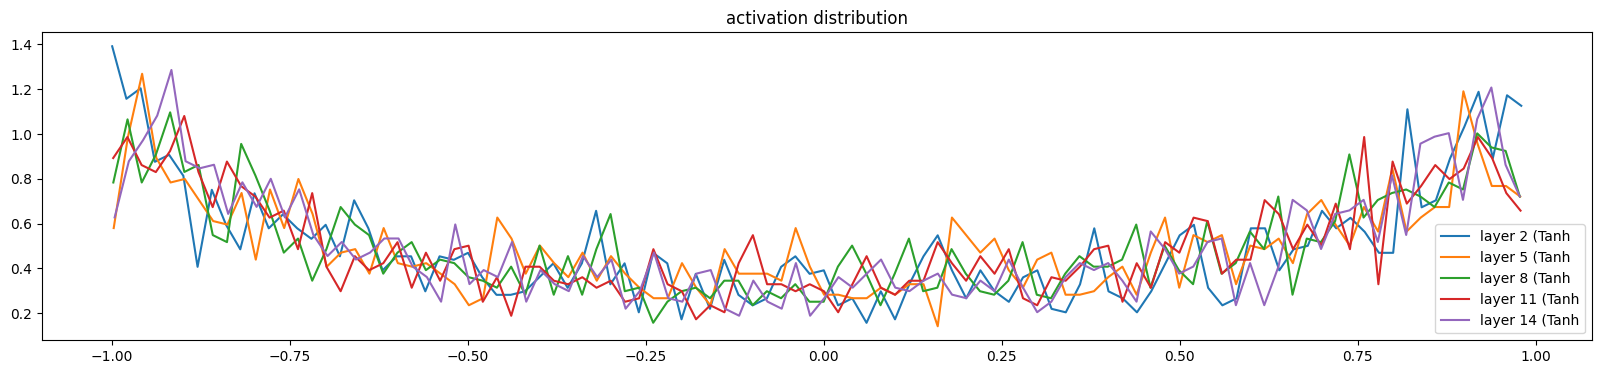

In [39]:
layers,_,_ = get_layers_with_BatchNorm_gain(gain=5/3.0, optimization_steps=1000)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

As we can see we have low saturation rates and stables standandard deviations (even almost equals) across all layers.

Number of params: 47551
      0/ 200000: 3.305029
999
layer 0 (    Linear): mean -0.000000, std 1.287537e-03
layer 3 (    Linear): mean -0.000000, std 1.384277e-03
layer 6 (    Linear): mean +0.000000, std 1.295764e-03
layer 9 (    Linear): mean +0.000000, std 1.169592e-03
layer 12 (    Linear): mean -0.000000, std 1.104188e-03
layer 15 (    Linear): mean +0.000000, std 2.196093e-03


Text(0.5, 1.0, 'gradient distribution')

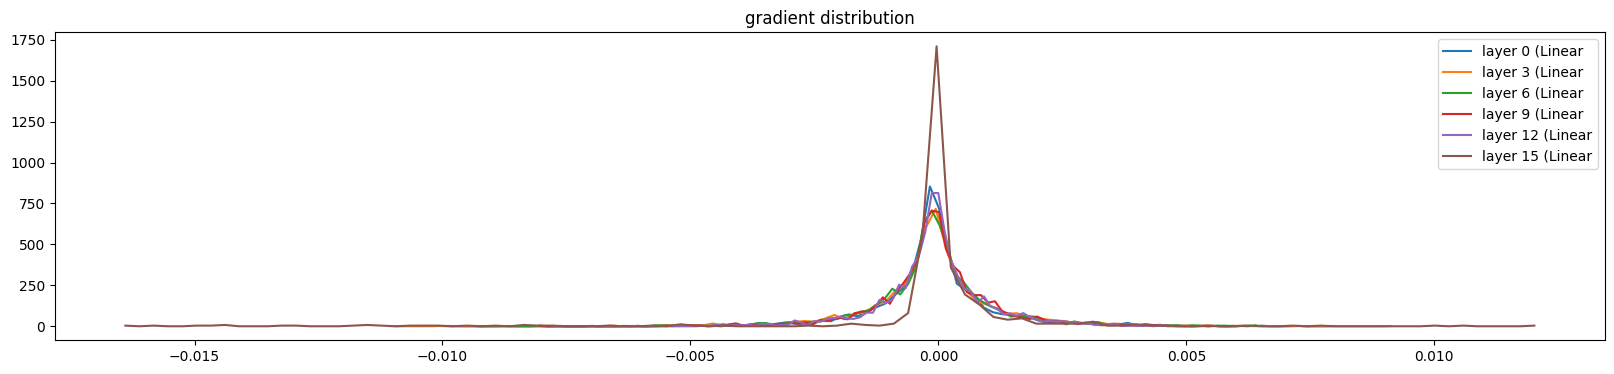

In [41]:
layers,_,_ = get_layers_with_BatchNorm_gain(gain=5/3.0, optimization_steps=1000)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

We have also pretty good and stables gradients

Number of params: 47551
      0/ 200000: 3.305266
999
weight   (27, 10) | mean +0.000000 | std 7.741205e-03 | grad:data ratio 7.736321e-03
weight  (30, 100) | mean -0.000057 | std 7.260359e-03 | grad:data ratio 2.398797e-02
weight (100, 100) | mean +0.000057 | std 5.796222e-03 | grad:data ratio 3.477355e-02
weight (100, 100) | mean +0.000005 | std 5.036005e-03 | grad:data ratio 2.994118e-02
weight (100, 100) | mean -0.000088 | std 4.387363e-03 | grad:data ratio 2.598752e-02
weight (100, 100) | mean -0.000052 | std 3.986192e-03 | grad:data ratio 2.381452e-02
weight  (100, 27) | mean -0.000128 | std 7.454890e-03 | grad:data ratio 4.285523e-02


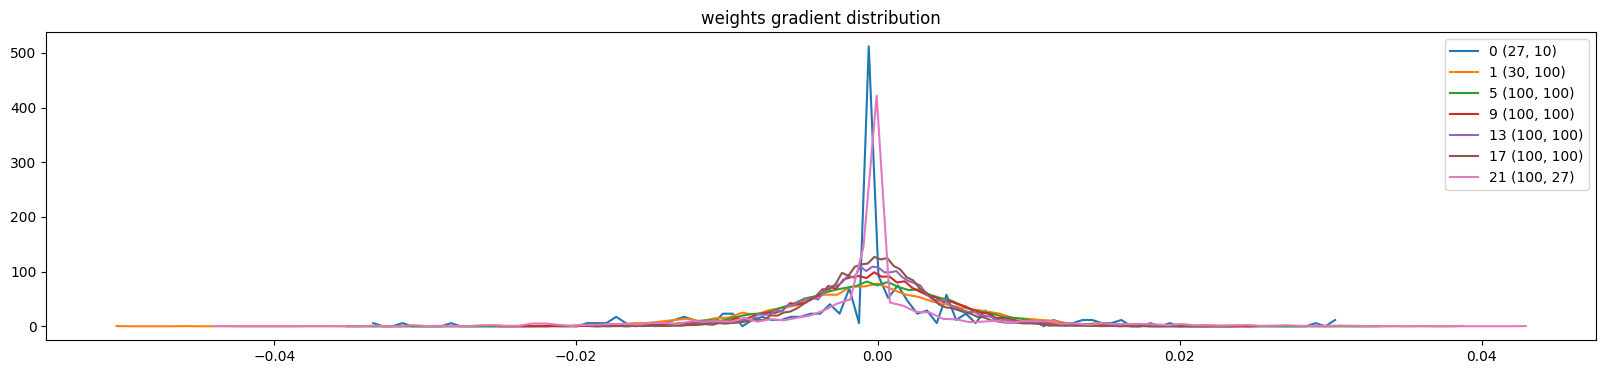

In [47]:
layers, parameters, _ = get_layers_with_BatchNorm_gain(gain=5/3.0, optimization_steps=1000)

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim==2 and p.shape[0]>1:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

The weights distribution looks good, maybe the plot is a bit different for first and last layer but the std and ratios are pretty similar among layers.

Number of params: 47551
      0/ 200000: 3.293570
999


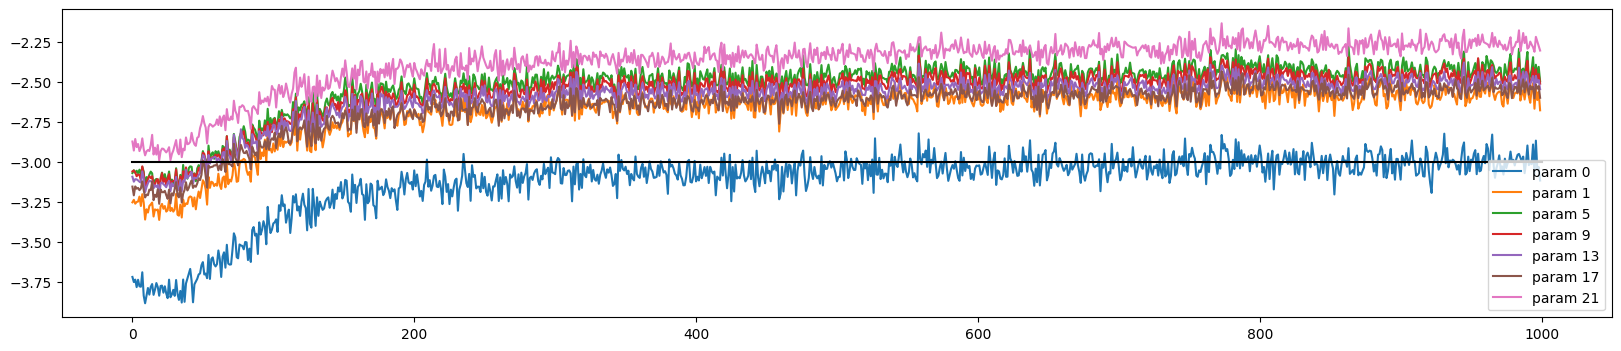

In [49]:
layers, parameters, ud = get_layers_with_BatchNorm_gain(gain=5/3.0, optimization_steps=1000)

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim==2 and p.shape[0]>1:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Good situation in update to data ratio too, all the layers are close to the `-3` desired ratio, most of them are above this value but not by too much, so we are ok. Another important point is that all the values, except for the first layer, are pretty similars.

Now that we have seen that our network behave pretty well with the BatchNorm layer, let see if it is now more robust to change in the parameters. For example let's try to modify the gain of the linear layers in the initialization, we will replace the `5/3.0` by `0.2`, a values noticeable smaller:

47024
      0/ 200000: 3.2870
layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 2.00%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 1.47%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 1.22%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 0.72%


Text(0.5, 1.0, 'activation distribution')

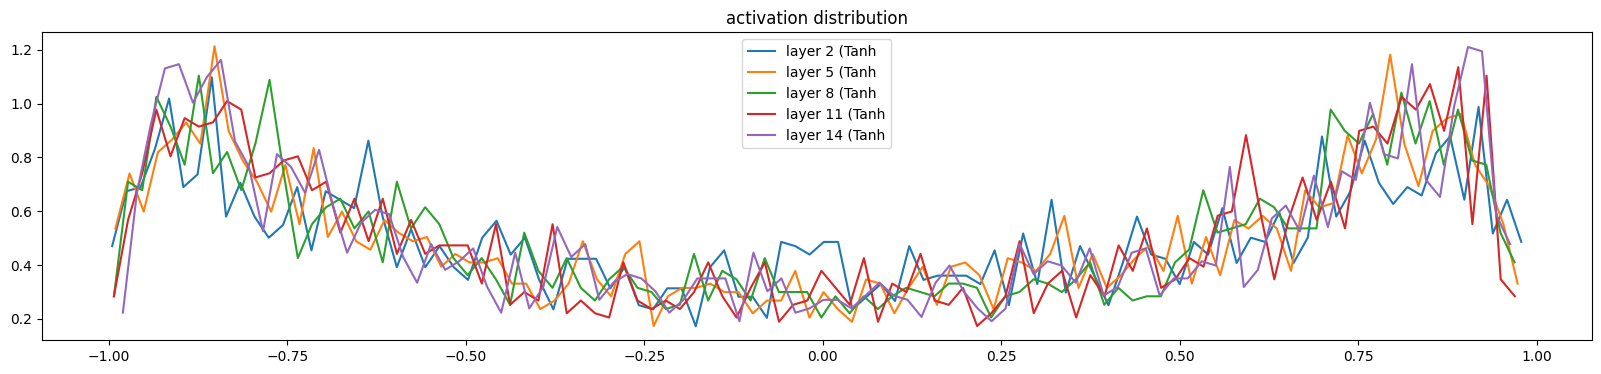

In [52]:
#layers,_,_ = get_layers_with_BatchNorm_gain(gain=0.2, optimization_steps=1000)

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size=27
block_size =3
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.2#1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

As we can see with the new gain do not affect to the distribution of the activatios, roughly the same std, and a very low ratio of saturated values.

layer 0 (    Linear): mean -0.000000, std 2.890978e-03
layer 3 (    Linear): mean +0.000000, std 1.876720e-03
layer 6 (    Linear): mean -0.000000, std 1.688342e-03
layer 9 (    Linear): mean -0.000000, std 1.618554e-03
layer 12 (    Linear): mean +0.000000, std 1.596114e-03
layer 15 (    Linear): mean +0.000000, std 3.803026e-03


Text(0.5, 1.0, 'gradient distribution')

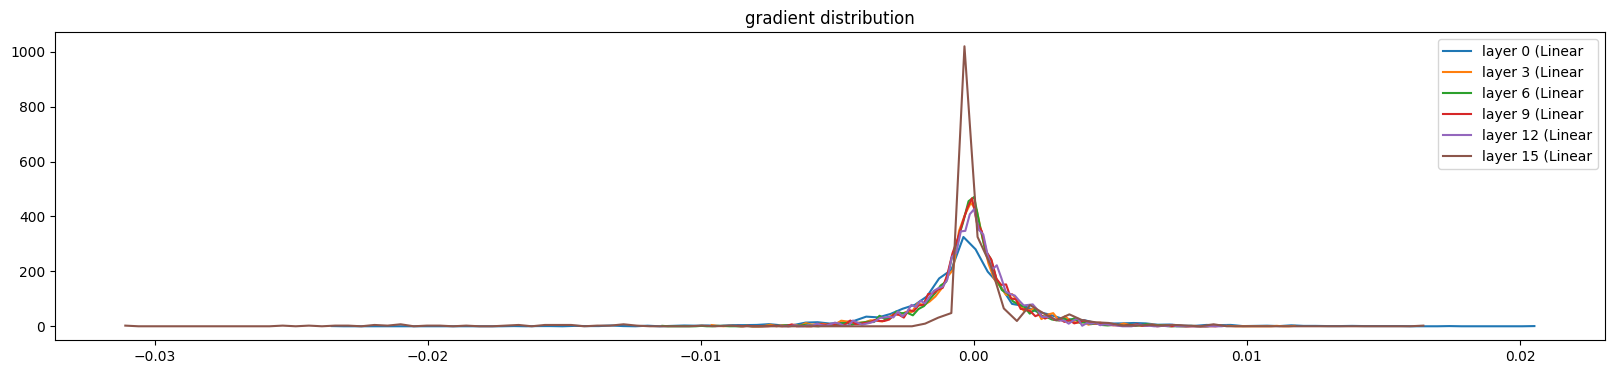

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.373104e-03 | grad:data ratio 7.366225e-03
weight  (30, 100) | mean +0.000311 | std 1.391910e-02 | grad:data ratio 2.291524e-01
weight (100, 100) | mean +0.000029 | std 6.005445e-03 | grad:data ratio 2.009050e-01
weight (100, 100) | mean -0.000016 | std 5.219661e-03 | grad:data ratio 1.905846e-01
weight (100, 100) | mean -0.000050 | std 5.058508e-03 | grad:data ratio 1.921146e-01
weight (100, 100) | mean -0.000113 | std 5.221349e-03 | grad:data ratio 2.003026e-01
weight  (100, 27) | mean +0.000016 | std 1.234927e-02 | grad:data ratio 2.863972e-01


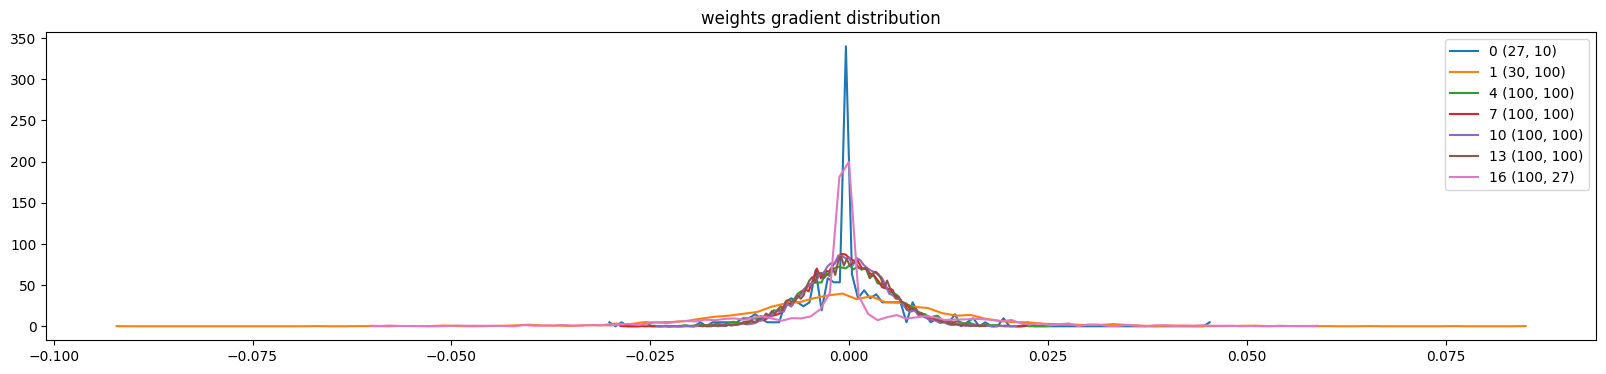

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim==2 and p.shape[0]>1:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

The weights and gradients are stable across layers

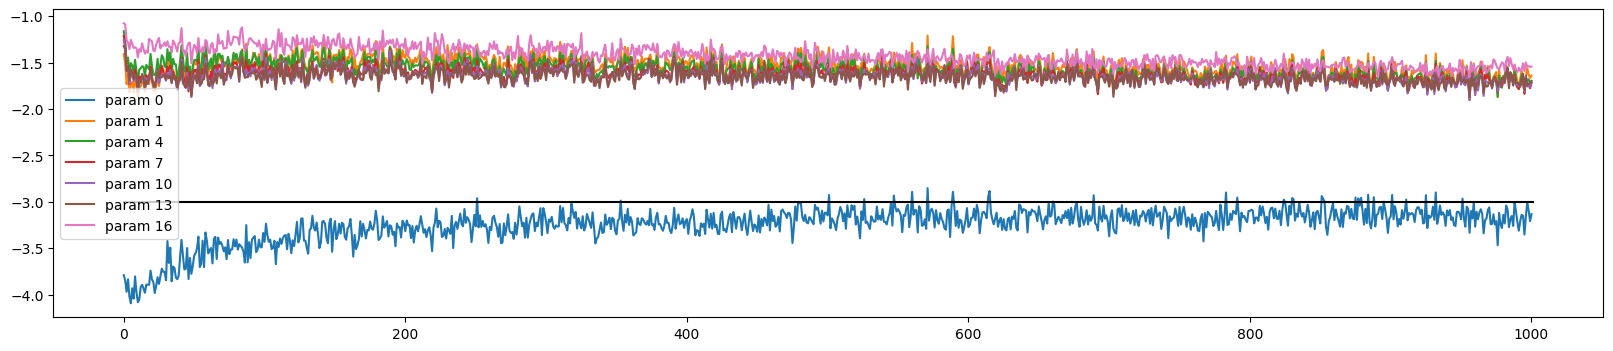

In [55]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim==2 and p.shape[0]>1:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The update to data ratio does not seem Ok, the ratio is to high, far away from the desired `-3`. But even with this problem the network looks pretty robust.


The last exepriment will be remove all the gains from linear layer, the one that we apply in the initialization and the one that we apply in the definition:


47024
      0/ 200000: 3.2870
layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%


Text(0.5, 1.0, 'activation distribution')

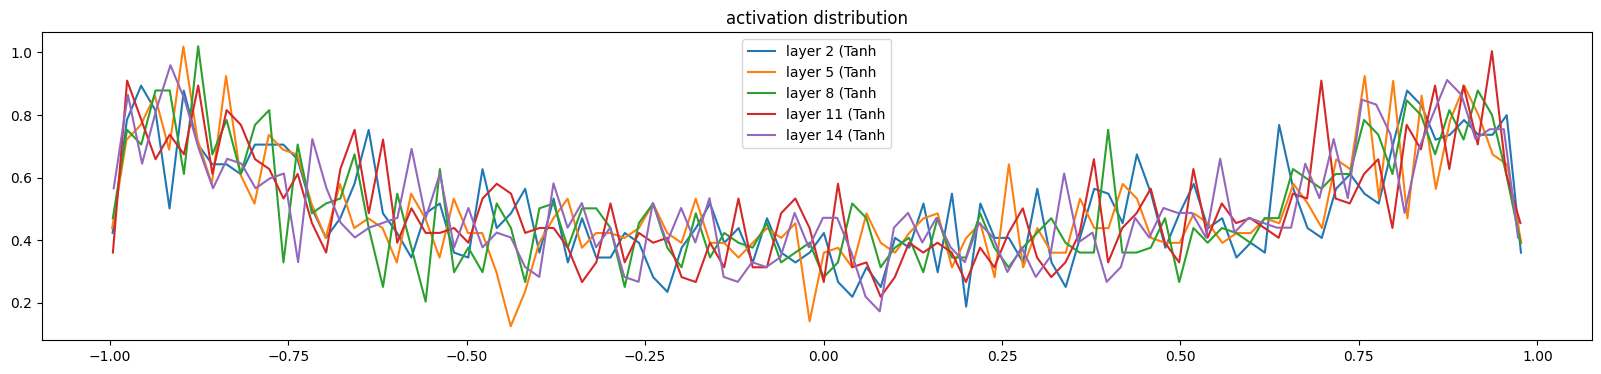

In [56]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size=27
block_size =3
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean -0.000000, std 4.261200e-04
layer 3 (    Linear): mean -0.000000, std 3.183692e-04
layer 6 (    Linear): mean +0.000000, std 2.803649e-04
layer 9 (    Linear): mean -0.000000, std 2.507718e-04
layer 12 (    Linear): mean +0.000000, std 2.268857e-04
layer 15 (    Linear): mean -0.000000, std 3.665986e-04


Text(0.5, 1.0, 'gradient distribution')

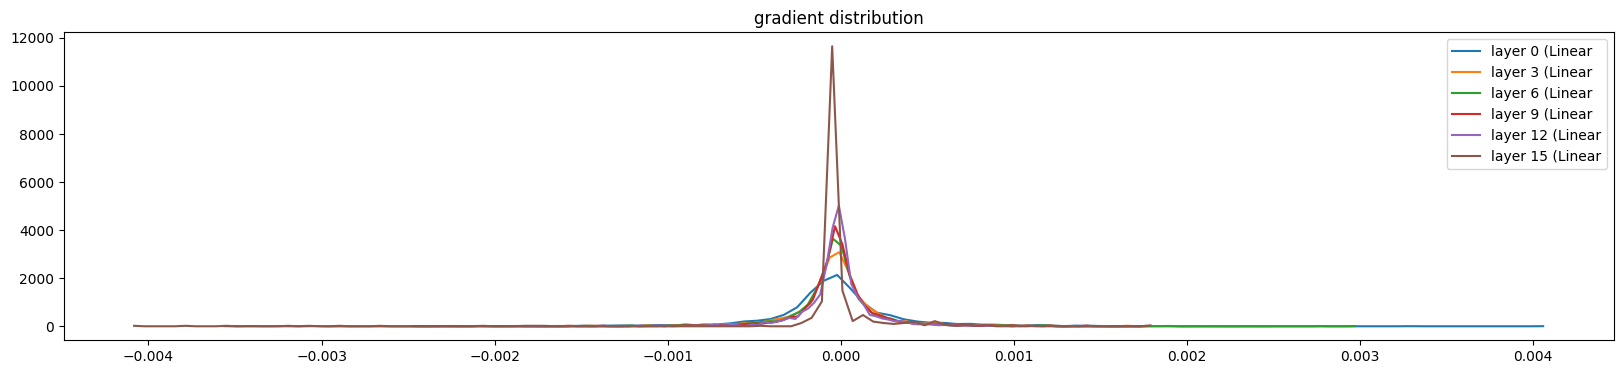

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 6.705949e-03 | grad:data ratio 6.700180e-03
weight  (30, 100) | mean -0.000003 | std 2.026517e-03 | grad:data ratio 1.977297e-03
weight (100, 100) | mean +0.000013 | std 1.104427e-03 | grad:data ratio 1.108055e-03
weight (100, 100) | mean +0.000005 | std 9.566541e-04 | grad:data ratio 9.497146e-04
weight (100, 100) | mean +0.000003 | std 8.406343e-04 | grad:data ratio 8.380436e-04
weight (100, 100) | mean +0.000001 | std 7.872586e-04 | grad:data ratio 7.840729e-04
weight  (100, 27) | mean -0.000002 | std 1.212761e-03 | grad:data ratio 1.226612e-03


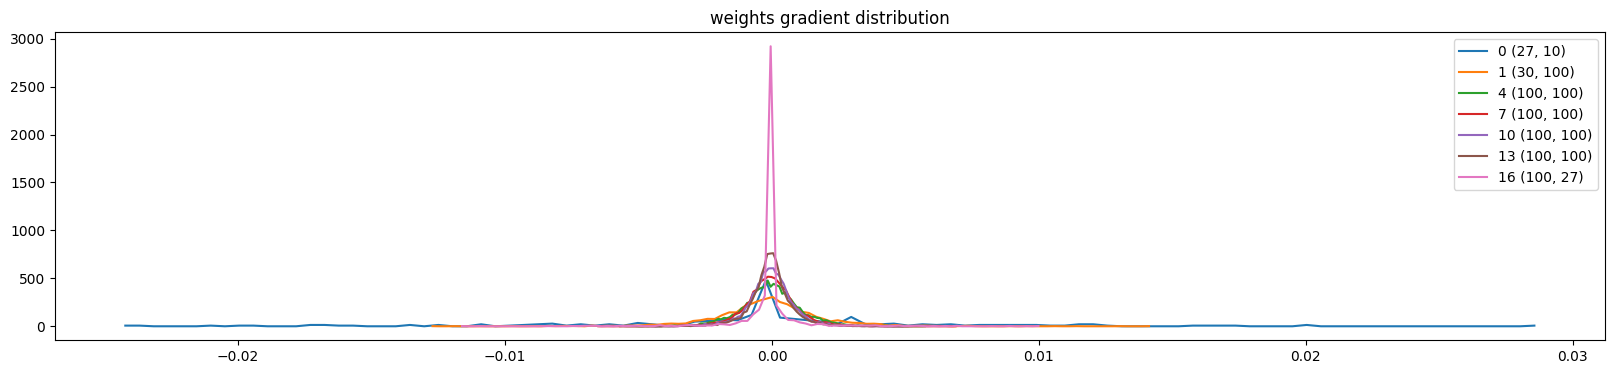

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim==2 and p.shape[0]>1:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

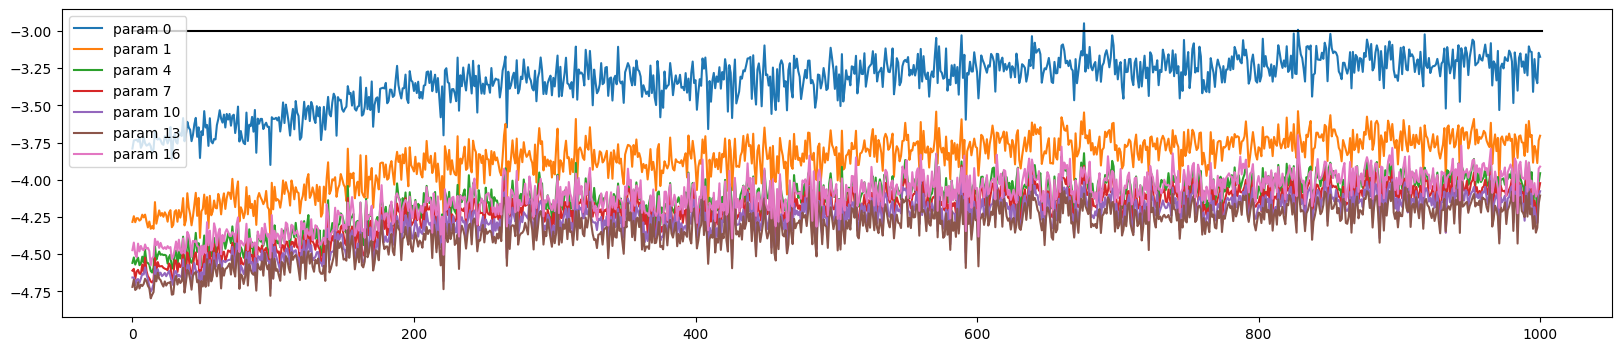

In [59]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim==2 and p.shape[0]>1:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The only issue seem to be again the update to data ratio, it seems a little bit low. But we can fix it easily increasing the learning rate.

47024
      0/ 200000: 3.2870


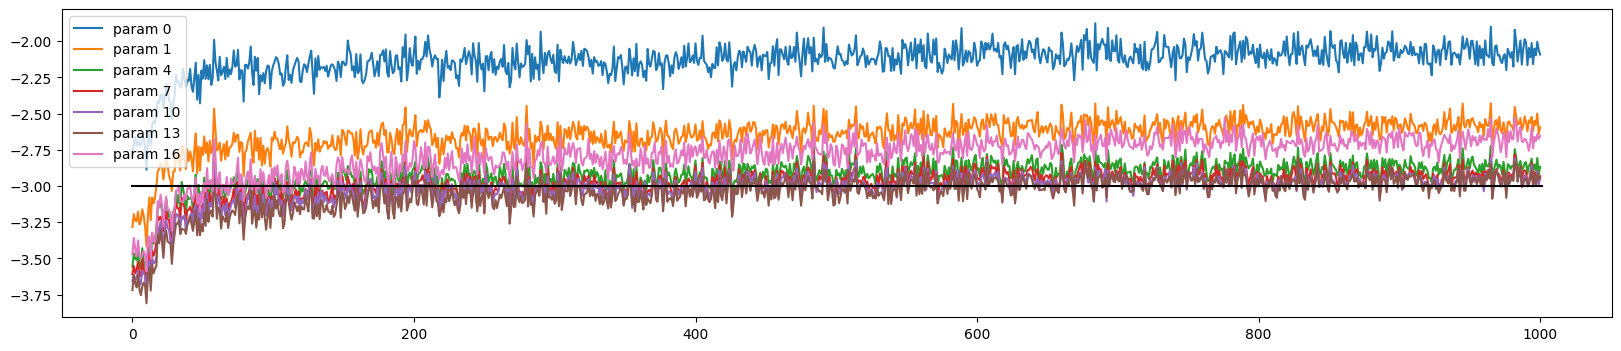

In [61]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size=27
block_size =3
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 1.0
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim==2 and p.shape[0]>1:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);